In [8]:
#https://github.com/Finspire13/pytorch-policy-gradient-example/blob/master/pg.py
#https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html#deriving-the-simplest-policy-gradient

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

In [9]:
%load_ext autoreload
%autoreload 2

from bs_helpers import *
from bs_gameclass import *
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
net = bs_unet()
net.load_state_dict(torch.load('data/battleships_unet.dat'))
net.optim = torch.optim.Adam(lr=0.0001, betas=(0., 0.999), params=net.parameters())

In [11]:
gamma = 0.8

In [22]:
def batchgen(games, size, verbose=1):
    
    while True:
        indlist = np.random.permutation(range(len(games)))
        minibatches = [ indlist[k*size:(k+1)*size] for k in range(len(indlist)//size) ]
        
        for mb in minibatches:
            xs = np.zeros((size, SX, SY, 3))
            vms = np.zeros((size, SX, SY, 1))
            ys = np.zeros((size, SX, SY, 1))
            rs = np.zeros((size))
            for k, l in enumerate(mb):
                s, (i,j), r = games[l]
                xs[k] = encode_x(s.sea, s.det)
                ys[k, i, j] = 1.
                vms[k,:,:,0] = 1-s.det
                if np.random.rand()<.5:
                    xs[k] = xs[k,:,::-1]
                    ys[k] = ys[k,:,::-1]
                    vms[k] = vms[k,:,::-1]
                if np.random.rand()<.5:
                    xs[k] = xs[k,::-1]
                    ys[k] = ys[k,::-1]
                    vms[k] = vms[k,::-1]
                if np.random.rand()<.5:
                    xs[k] = xs[k].transpose(1,0,2)
                    ys[k] = ys[k].transpose(1,0,2)
                    vms[k] = vms[k].transpose(1,0,2)
                rs[k] = r
            yield xs, ys, vms, rs
        if verbose:
            print('Finished one batchgen epoch!')

In [23]:

for epoch in range(9999999):

    # Play some games
    games = []
    glengths = []
    for _ in trange(100):
        s = GameState()
        h = create_sea()
        single_game = []
        while not GameClass.getEnded(s):
            #plot_sea(s.sea, s.det)
            #plt.show()
            if np.random.rand() < 0.1:
                vms = GameClass.getValidActions(s)
                l = np.random.choice(len(vms))
                i, j = vms[l]
            else:
                prob = net.predict(encode_x(s.sea, s.det))
                i, j = argmax2d(prob-9999*s.det)
            r = h[i,j] # reward
            single_game.append((s, (i,j), r))
            s = GameClass.getNextState(s, (i,j), hidden=h)
            
        # Cumulate reward
        cr = 0.
        for s, (i,j), r in reversed(single_game):
            cr = gamma*cr + r
            games.append((s, (i,j), cr))
        glengths.append(len(single_game))
    
    print('Game length mean', np.mean(glengths))
    
    
    # normalize the cumulated reward
    rs = [ r for s, (i,j), r in games ]
    mn = np.mean(rs)
    games = [ (s, (i,j), (r-mn)) for s, (i,j), r in games ]
    
    # train the nnet
    bg = batchgen(games, size=32)
    losses = []
    
    #raise
    for k in trange(600): 
        xs, ys, vms, rs = next(bg)
        xs, ys, vms, rs = np2t(xs, ys, vms, rs)
        net(xs)
        p = net.p-9999*(1-vms)
        p = softmax2d(p)
        loss = torch.mean(-rs*ys*torch.log(p+1e-12))
        #print(loss)
        loss.backward()
        net.optim.step()
        net.optim.zero_grad()
        losses.append(loss.item())
        if k%100 == 0:
            print(np.mean(losses))
            losses = []

  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 74.16


  0%|          | 0/600 [00:00<?, ?it/s]

0.0043895128183066845
0.00042473451841942736
0.00033570347572094763
Finished one batchgen epoch!
-0.0006516125933239891
0.0007311690085407463
Finished one batchgen epoch!
-0.001072150402033003


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 79.9


  0%|          | 0/600 [00:00<?, ?it/s]

0.00446203863248229
0.0005638840800747857
-0.000571350195168634
Finished one batchgen epoch!
-0.00034905524775240336
-0.0021845538720026525
Finished one batchgen epoch!
0.0032769517928682036


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 78.12


  0%|          | 0/600 [00:00<?, ?it/s]

0.004416484385728836
-0.0006750157249780386
0.0009290307237279194
Finished one batchgen epoch!
-0.0019820038742727774
0.00021601678105071187
Finished one batchgen epoch!
0.0004129365754124592


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 78.13


  0%|          | 0/600 [00:00<?, ?it/s]

-0.0009603336220607162
-0.0002187375084758969
-0.0005315799078380223
Finished one batchgen epoch!
2.6173276419285686e-05
-0.00012847596713982056
Finished one batchgen epoch!
-0.0024280480394372715


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 81.84


  0%|          | 0/600 [00:00<?, ?it/s]

-0.0010103407548740506
-0.0005932237304295995
-0.0010590198873978807
Finished one batchgen epoch!
-0.0010071048514510039
-0.0012773287249729036
0.0021444409724790604
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 78.78


  0%|          | 0/600 [00:00<?, ?it/s]

-0.0019677169620990753
-0.000472792022737849
-0.0024063602746173273
Finished one batchgen epoch!
0.0011502848309464754
0.00013920349741965764
Finished one batchgen epoch!
-0.0037000229873956412


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 82.78


  0%|          | 0/600 [00:00<?, ?it/s]

-0.00689665786921978
0.000420876064163167
-0.0052073486339941156
Finished one batchgen epoch!
0.0023483049556671178
-0.0011945053299859865
-0.006399384989927057
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 79.83


  0%|          | 0/600 [00:00<?, ?it/s]

-0.040276359766721725
0.0005754799518035724
-0.0015622916611300753
Finished one batchgen epoch!
-0.00328584584989585
-0.00459997271100292
Finished one batchgen epoch!
0.0008223335803631926


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 81.44


  0%|          | 0/600 [00:00<?, ?it/s]

-0.0461609847843647
-9.561633967678063e-05
-0.002506597036262974
Finished one batchgen epoch!
-0.006520553821901558
-0.008301119492425641
-0.004308879091768176
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 81.41


  0%|          | 0/600 [00:00<?, ?it/s]

0.004691571928560734
-0.0046563714108197015
-0.0028672470013771088
Finished one batchgen epoch!
0.0006795995541324373
-0.0007868411926392582
-0.004312842724320944
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 79.68


  0%|          | 0/600 [00:00<?, ?it/s]

0.1120850145816803
0.00028993926680414005
-0.0033712079192628154
Finished one batchgen epoch!
-0.0027139646535215434
-0.002464012131858908
Finished one batchgen epoch!
-0.0037386512399280036


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 83.32


  0%|          | 0/600 [00:00<?, ?it/s]

-0.02059471607208252
0.0031268879951676354
-0.0014762533122848255
Finished one batchgen epoch!
-0.0033510471586487255
-0.0023500728094950317
-0.0043497869643033486
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 81.37


  0%|          | 0/600 [00:00<?, ?it/s]

0.0002804553078021854
-0.0074635168878012335
-0.0015796750365188927
Finished one batchgen epoch!
-0.008868591167556587
-0.0025959884420444722
-0.0041140346190150015
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 81.95


  0%|          | 0/600 [00:00<?, ?it/s]

-0.11892323940992355
-0.007743496242910624
0.0015996195672778413
Finished one batchgen epoch!
-0.00659568173752632
-0.001157993084489135
-0.004789158137646155
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 80.79


  0%|          | 0/600 [00:00<?, ?it/s]

-0.0009781122207641602
-0.001851641525499872
-0.008887127045745728
Finished one batchgen epoch!
0.004557787034864305
0.0023467680763860697
-0.003456327035673894
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 81.74


  0%|          | 0/600 [00:00<?, ?it/s]

-0.002438010647892952
-0.004538666680455208
-0.0064182962004997535
Finished one batchgen epoch!
0.0019350308589127963
-0.00244296136428602
0.0011879647515888791
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 85.86


  0%|          | 0/600 [00:00<?, ?it/s]

-0.062385473400354385
-0.0037786120001692325
0.0026676640007644893
Finished one batchgen epoch!
0.0019207798622664996
-0.0038452076210523955
0.0029119469714351
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 82.73


  0%|          | 0/600 [00:00<?, ?it/s]

-0.016082432121038437
0.0028946248449210543
-0.001577214802382514
Finished one batchgen epoch!
-0.0033314128840356717
0.0025168882570869755
-0.004839062501669105
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 83.32


  0%|          | 0/600 [00:00<?, ?it/s]

-0.07372792810201645
-0.005547007173299789
-0.006133739572987906
Finished one batchgen epoch!
-0.0025857726167305374
-0.0054334458889752565
-0.010047501487424598
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 83.21


  0%|          | 0/600 [00:00<?, ?it/s]

-0.0007668751059100032
-0.0033059099488309584
-0.0010950339725968661
Finished one batchgen epoch!
-0.0046535304178541995
-0.0006497648273943923
-0.0056702092006162275
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 84.45


  0%|          | 0/600 [00:00<?, ?it/s]

-0.0018999861786141992
-0.003331051346176537
0.00020783375104656442
Finished one batchgen epoch!
-0.0016350785339818686
-0.0024086707617971114
-0.010655536044141626
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 85.32


  0%|          | 0/600 [00:00<?, ?it/s]

0.001435307553038001
-0.005452897754275909
-0.005844191795622464
Finished one batchgen epoch!
-0.00936093302356312
-0.005196391397003026
-0.0019934457875206133
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 83.7


  0%|          | 0/600 [00:00<?, ?it/s]

-0.009454765357077122
-0.0007557043423003051
-0.00443180487898644
Finished one batchgen epoch!
-0.003960738413443323
-0.001280264955421444
-0.002917324649897637
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 84.75


  0%|          | 0/600 [00:00<?, ?it/s]

0.0010655391961336136
-0.0025186466689774535
-0.0024755590694803685
Finished one batchgen epoch!
-0.0033436331877601333
-0.002543641501906677
-0.0018111993389902637
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 87.74


  0%|          | 0/600 [00:00<?, ?it/s]

-0.05225139483809471
0.005494989775761496
-0.004275407765235286
Finished one batchgen epoch!
-0.0030699840152635717
-0.0019265478253510083
-0.0030838572086940986
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 83.43


  0%|          | 0/600 [00:00<?, ?it/s]

0.008344607427716255
-0.0014326336231533787
-0.011085351613510284
Finished one batchgen epoch!
2.2671321421512402e-05
-0.0027204657882475658
-0.0038002338741353016
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 86.09


  0%|          | 0/600 [00:00<?, ?it/s]

0.001843697507865727
-0.0015184423225582577
-0.003004538286713796
Finished one batchgen epoch!
-0.003131655890174443
-0.0011515259424049872
-0.003240950457038707
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 83.91


  0%|          | 0/600 [00:00<?, ?it/s]

-0.0037060496397316456
-0.006622401509125666
-0.004489418642979217
Finished one batchgen epoch!
-0.0013539572403533384
-0.006717514565389137
-0.001778962023963686
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 88.27


  0%|          | 0/600 [00:00<?, ?it/s]

-0.004380036611109972
-0.004671810475301754
-0.0009343086008448153
Finished one batchgen epoch!
-1.315835805144161e-05
-0.003197830724493542
-0.0003585352964728372
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 85.08


  0%|          | 0/600 [00:00<?, ?it/s]

0.04033999517560005
-0.0038908079479006118
-0.00774913103756262
Finished one batchgen epoch!
-0.00483583259570878
-0.006317083150461258
-0.0052688326174120444
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 90.34


  0%|          | 0/600 [00:00<?, ?it/s]

-0.0015103446785360575
-0.002865141848797066
0.002840875797555782
Finished one batchgen epoch!
-0.0041873625657171945
-0.0024015233131649437
-0.0024973007373773727
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 88.64


  0%|          | 0/600 [00:00<?, ?it/s]

-0.03474394232034683
-0.002330577396642184
-0.003952626453246922
Finished one batchgen epoch!
-0.0011592968928744085
-0.002130805674241856
0.0007054256696574158
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 85.37


  0%|          | 0/600 [00:00<?, ?it/s]

-0.0002229671081295237
-0.003685115749249235
-0.005690803906763904
Finished one batchgen epoch!
0.00010166073385335039
-0.0067585381683602464
-0.0071892482300347635
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 83.31


  0%|          | 0/600 [00:00<?, ?it/s]

-0.0037951176054775715
-0.0038397814106428995
-0.000533785659536079
Finished one batchgen epoch!
-0.0008323959319932328
-0.00460157522407826
-0.001766544602869544
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 84.49


  0%|          | 0/600 [00:00<?, ?it/s]

0.0043379440903663635
-0.0029611411008227152
-0.004283908837642229
Finished one batchgen epoch!
-0.004991452505782945
-0.0012980004572455072
-0.0033116883973707445
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 84.82


  0%|          | 0/600 [00:00<?, ?it/s]

-0.0017782620852813125
-0.006113655665358237
0.0011754993203794584
Finished one batchgen epoch!
-0.003465705570342834
0.00030895261020305045
-0.005395893845961837
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 83.56


  0%|          | 0/600 [00:00<?, ?it/s]

0.007895033806562424
-0.005234777187288273
-0.004083541994332336
Finished one batchgen epoch!
-0.005243447062966879
0.0008446324331816868
-0.007355058733810438
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 84.24


  0%|          | 0/600 [00:00<?, ?it/s]

0.01185418851673603
-0.004685970623831963
-0.0043854740230017345
Finished one batchgen epoch!
-8.752752808504737e-05
-0.0052742345320530145
-0.00016957504558376968
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 84.46


  0%|          | 0/600 [00:00<?, ?it/s]

-0.00521303154528141
-0.0035523121512960644
-0.0021786231251462594
Finished one batchgen epoch!
-0.006153306007763604
-0.003923136321827769
-0.0008360667265515077
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 83.39


  0%|          | 0/600 [00:00<?, ?it/s]

-0.02643878385424614
-0.006143245890471007
-0.0010100006639549974
Finished one batchgen epoch!
-0.007005724934242607
-0.0013838950666740857
-0.011430745816323907
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 87.91


  0%|          | 0/600 [00:00<?, ?it/s]

0.03220221772789955
0.0017528640586533585
-0.0075744576343277
Finished one batchgen epoch!
-0.005483087546163006
-0.005844651511870325
-0.006745463411070887
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 84.52


  0%|          | 0/600 [00:00<?, ?it/s]

-0.027986034750938416
-0.005287095655221492
-0.005535938140237704
Finished one batchgen epoch!
-0.006362476923895883
-0.0071751179943385065
-0.003952857716731159
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 85.91


  0%|          | 0/600 [00:00<?, ?it/s]

-0.001039705122821033
-0.0006055072302842745
-0.0025323766443761998
Finished one batchgen epoch!
-0.0025357141690983552
-0.003496469055255602
-0.008226542317133862
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 85.68


  0%|          | 0/600 [00:00<?, ?it/s]

0.026097174733877182
-0.006195653227150615
-0.003947660082885705
Finished one batchgen epoch!
-0.004358964858638501
-0.005043251908573438
-0.0034250747612531995
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 84.46


  0%|          | 0/600 [00:00<?, ?it/s]

-0.042849503457546234
-0.006538966175940004
-0.007319089935699594
Finished one batchgen epoch!
-0.006412297587157809
-0.00787381780857686
-0.00435100304603111
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 84.45


  0%|          | 0/600 [00:00<?, ?it/s]

-0.005281372927129269
-0.003315082723420346
-0.006495345622752211
Finished one batchgen epoch!
-0.006404896504536736
-0.0019222146564425201
-0.005755047871207353
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 82.78


  0%|          | 0/600 [00:00<?, ?it/s]

-0.0009740946115925908
-0.008491775647853502
0.00018721443921094761
Finished one batchgen epoch!
-0.0048625657727825455
-0.0027904449074412697
-0.007255272968941426
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 84.69


  0%|          | 0/600 [00:00<?, ?it/s]

0.05630524829030037
-0.00028463426431926567
-0.0009681817483215128
Finished one batchgen epoch!
-0.005245064796763472
-0.003879424141050549
-0.003677525458879245
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 84.62


  0%|          | 0/600 [00:00<?, ?it/s]

-0.04499759525060654
-0.0011689655922236851
-0.007882885271392297
Finished one batchgen epoch!
-0.004410032257292187
-0.00911931268103217
-0.0029724892493686638
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 83.12


  0%|          | 0/600 [00:00<?, ?it/s]

-0.04299044981598854
-0.004710335556101199
-0.0005220208933678805
Finished one batchgen epoch!
-0.006394254379702033
-0.005675563809636515
-0.004624551286324277
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 85.77


  0%|          | 0/600 [00:00<?, ?it/s]

0.002878497587516904
-0.005599757334275637
-0.006720506683705025
Finished one batchgen epoch!
-0.008554310074323439
-0.005974741042518872
0.002509462365414947
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 86.56


  0%|          | 0/600 [00:00<?, ?it/s]

-0.023676428943872452
-0.0062506902782479305
-0.004225948201619758
Finished one batchgen epoch!
-0.0027962564701010705
-0.0015213633240273338
0.0005226711655268446
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 85.52


  0%|          | 0/600 [00:00<?, ?it/s]

0.005200226325541735
-0.0003682354831835255
-0.001956853835599759
Finished one batchgen epoch!
0.0008605154624092392
-0.002912636260396084
0.0016324619723309297
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 86.44


  0%|          | 0/600 [00:00<?, ?it/s]

-0.00298511260189116
0.00046042831614613534
-0.0006108755406785349
Finished one batchgen epoch!
-0.0024300387589028106
-0.0035284208599478005
9.438615961698815e-05
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 88.1


  0%|          | 0/600 [00:00<?, ?it/s]

-0.023948470130562782
-0.0008892187013407238
0.00024098074056382756
Finished one batchgen epoch!
-0.0013988141612207982
-0.0011416998259664978
-0.001591334841969001
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 89.72


  0%|          | 0/600 [00:00<?, ?it/s]

0.005716634914278984
-0.00035833640868077055
-0.0005453445207967888
Finished one batchgen epoch!
-0.004306001845980063
-0.005921750629786402
0.0019107313378481194
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 89.67


  0%|          | 0/600 [00:00<?, ?it/s]

0.012046159245073795
-0.0007133550936123356
-0.006686881973582786
Finished one batchgen epoch!
-0.004655691218067659
0.003325021499331342
-0.001526469745731447
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 87.9


  0%|          | 0/600 [00:00<?, ?it/s]

-0.01913333684206009
-0.005621482904825825
-0.0041381358676881065
Finished one batchgen epoch!
-0.006104276718651817
0.0002965152319666231
-0.0016197231872934026
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 87.93


  0%|          | 0/600 [00:00<?, ?it/s]

0.003602007869631052
-0.007925013363565086
-0.0016340471006697044
Finished one batchgen epoch!
-0.007356773353531025
-0.00610232249229739
-0.004824851108714938
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 91.6


  0%|          | 0/600 [00:00<?, ?it/s]

0.023863350972533226
-0.0037323530967114495
0.0020218908132665094
Finished one batchgen epoch!
-0.005258559954672819
-0.0018790294578502652
-0.0009526457604806637
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 92.89


  0%|          | 0/600 [00:00<?, ?it/s]

-0.015207682736217976
-0.000114433485941845
-0.002557804017997114
Finished one batchgen epoch!
-0.0020420597580232424
-0.003078203602708527
-0.0023697002360131593
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 90.33


  0%|          | 0/600 [00:00<?, ?it/s]

-0.02595473639667034
-0.006082543120719493
0.002992333813745063
Finished one batchgen epoch!
-0.0008744353069050703
-0.0019189694452506957
-0.0010648126697924453
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 92.72


  0%|          | 0/600 [00:00<?, ?it/s]

-0.0002809402358252555
0.00043564005853113485
-0.002303872378251981
Finished one batchgen epoch!
-0.003048197606112808
-0.005588323333649896
0.003608541785579291
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 93.33


  0%|          | 0/600 [00:00<?, ?it/s]

0.047015268355607986
-0.0032007874359260315
-0.0021500684233615175
Finished one batchgen epoch!
0.0030343378355610186
-0.002389481201535091
-0.0006797962159907911
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 92.12


  0%|          | 0/600 [00:00<?, ?it/s]

0.009458036161959171
-0.0019432063325075433
-0.0049194756041833895
Finished one batchgen epoch!
-0.0006772880248900038
-0.0018788166759622982
-0.0015397699651839502
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 92.18


  0%|          | 0/600 [00:00<?, ?it/s]

0.01205518003553152
-0.0047247109145973805
-0.00202588810274392
Finished one batchgen epoch!
-0.007275943558342987
0.0018777013033104595
-0.0013905741856433452
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 91.68


  0%|          | 0/600 [00:00<?, ?it/s]

-0.0006967526278458536
-0.004373562419350492
-0.006522709308192134
Finished one batchgen epoch!
-0.0011186303672729991
-0.003810202301974641
-0.007938419290398997
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 93.53


  0%|          | 0/600 [00:00<?, ?it/s]

0.015557723119854927
-0.00037273888883646575
-0.006091782826697454
Finished one batchgen epoch!
-0.0018597610530559905
-0.00022359951385624298
-0.0022389480256242676
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 90.94


  0%|          | 0/600 [00:00<?, ?it/s]

-0.0002196126733906567
-0.0020025638765946495
-0.002619992254039971
Finished one batchgen epoch!
-0.00790611598000396
-0.0015086671059543733
-0.0025779528109706007
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 93.37


  0%|          | 0/600 [00:00<?, ?it/s]

0.010907663963735104
-0.003576868257514434
0.000185241441213293
Finished one batchgen epoch!
0.00033229527305593363
-0.001790123904720531
-0.0034264203999191524
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 93.73


  0%|          | 0/600 [00:00<?, ?it/s]

-0.04552264139056206
0.0037744437129003925
0.002526195956306765
Finished one batchgen epoch!
-0.005892021097824909
0.009501104562805267
-0.0015950872472603806
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 92.56


  0%|          | 0/600 [00:00<?, ?it/s]

-0.02850290760397911
0.0019518586166668683
-0.002127898067701608
Finished one batchgen epoch!
0.001105542229488492
-0.001552611954321037
0.004292531359242275
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 93.77


  0%|          | 0/600 [00:00<?, ?it/s]

-0.0447370745241642
-0.0014823100559442537
8.106389199383557e-05
Finished one batchgen epoch!
0.0015349217934999616
-0.003386534389837834
0.0003544674532895442
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 93.11


  0%|          | 0/600 [00:00<?, ?it/s]

0.014845858328044415
-0.00397001989884302
-0.003829206413938664
Finished one batchgen epoch!
0.006097950498806313
0.0005310742335859686
0.0008485166187892901
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 92.68


  0%|          | 0/600 [00:00<?, ?it/s]

0.019740011543035507
-0.0023853602589224464
0.001124575027533865
Finished one batchgen epoch!
-0.0010308629053179174
0.0013015622394232196
-0.005629282805894036
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 92.33


  0%|          | 0/600 [00:00<?, ?it/s]

0.003577820025384426
-0.001964162343647331
-0.003138449272373691
Finished one batchgen epoch!
0.002665977820433909
-0.0030445258019608447
0.003234967204916757
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 91.09


  0%|          | 0/600 [00:00<?, ?it/s]

0.01076470222324133
-0.002267965308856219
0.001836202466802206
Finished one batchgen epoch!
-0.002415490155399311
0.0003465477001736872
-0.0008777559006921365
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 92.07


  0%|          | 0/600 [00:00<?, ?it/s]

-0.010353296995162964
-0.0006870855922170449
-0.003221006235908135
Finished one batchgen epoch!
-0.0018267872673459352
-0.002871012765681371
-0.002061645528738154
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 91.78


  0%|          | 0/600 [00:00<?, ?it/s]

-0.02560609206557274
-0.0016589633654803039
-0.0031784533720929176
Finished one batchgen epoch!
-0.0010451820108573883
0.0003130691459227819
-0.00024040333315497264
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 92.81


  0%|          | 0/600 [00:00<?, ?it/s]

-0.009082411415874958
0.0008329859848890919
-0.0018748722093368997
Finished one batchgen epoch!
-0.002619009086120059
-0.0008038057362136897
0.00048174257222854066
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 91.46


  0%|          | 0/600 [00:00<?, ?it/s]

0.003238765522837639
0.0002528882431624879
-0.0007938223018936697
Finished one batchgen epoch!
-0.0019583593621791805
-0.004992917225445126
0.006232394112157635
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 91.81


  0%|          | 0/600 [00:00<?, ?it/s]

-0.059332408010959625
-0.0032667156812385655
-0.0020661838919477306
Finished one batchgen epoch!
-0.0017681696322870265
-0.0028782672525267117
-0.004667580611421727
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 94.63


  0%|          | 0/600 [00:00<?, ?it/s]

-0.00178720080293715
-0.004207489148830064
0.0009893744828877971
Finished one batchgen epoch!
-0.0029681848887412343
-0.0008914809196721762
-0.00036357364733703436
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 92.33


  0%|          | 0/600 [00:00<?, ?it/s]

0.00808898825198412
-0.005113497508100409
-0.003524381857660046
Finished one batchgen epoch!
-0.0036612941512066755
-0.0005979216725972947
-0.005741681733950372
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 93.61


  0%|          | 0/600 [00:00<?, ?it/s]

0.015512349084019661
-0.005180440391341108
0.0018131722138787154
Finished one batchgen epoch!
-0.0008326818398199976
-0.0038108377507160185
-0.0054996070435299775
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 92.77


  0%|          | 0/600 [00:00<?, ?it/s]

0.004432031884789467
0.0011194839386735112
0.0005669906923867529
Finished one batchgen epoch!
-0.0047003306833357785
-0.0042815408255683
0.0008495910483179614
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 94.33


  0%|          | 0/600 [00:00<?, ?it/s]

-0.03305269032716751
0.0008847930604679277
0.0009350587778317276
Finished one batchgen epoch!
-0.000924046321233618
0.0003703575496911071
6.11839472912834e-05
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 93.36


  0%|          | 0/600 [00:00<?, ?it/s]

0.012377487495541573
-0.0017360367096262053
8.51689651608467e-05
Finished one batchgen epoch!
0.00015031941067718434
-0.00040297812533026447
0.0002445291233743774
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 92.68


  0%|          | 0/600 [00:00<?, ?it/s]

0.0026192008517682552
-0.0007553659688505831
-0.000339696828614251
Finished one batchgen epoch!
0.000543352779786801
0.00046799721942079485
-7.964147087477613e-05
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 94.2


  0%|          | 0/600 [00:00<?, ?it/s]

0.0079911844804883
-0.0004968366303364746
0.0006009495151374722
Finished one batchgen epoch!
-3.8784303433203605e-05
0.00045294170224224217
-0.00035771850467426704
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 93.33


  0%|          | 0/600 [00:00<?, ?it/s]

-0.032739605754613876
0.0002960214117047144
-0.00035393865773585275
Finished one batchgen epoch!
0.00011490575969219207
0.0005466975217859727
1.1299543839413673e-05
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 93.92


  0%|          | 0/600 [00:00<?, ?it/s]

0.012096850201487541
0.0005121429341670592
-0.0006335994603432482
Finished one batchgen epoch!
-0.0007440122189291287
-0.002666943881631596
0.0009654111669806297
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 91.51


  0%|          | 0/600 [00:00<?, ?it/s]

0.009098926559090614
-0.0009279860232254578
0.0013358948811583104
Finished one batchgen epoch!
-0.001149621325021144
0.001305926048080437
-0.00010663443197699962
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 90.76


  0%|          | 0/600 [00:00<?, ?it/s]

-0.00038543541450053453
-0.00020246203075657832
0.0008684428162814583
Finished one batchgen epoch!
-0.0005131130220979685
-0.000869341797101697
0.0013693902209342924
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 90.35


  0%|          | 0/600 [00:00<?, ?it/s]

-0.01913178712129593
-0.0008140514354454353
0.0016992001130711287
Finished one batchgen epoch!
-0.0008945890207542106
0.0016115863707818789
-0.000387592783808941
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 90.47


  0%|          | 0/600 [00:00<?, ?it/s]

0.0013350527733564377
-0.0022134573576840923
0.001229690692271106
Finished one batchgen epoch!
0.0002592065103090135
-0.00093948851514142
0.0019273564831382827
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 89.11


  0%|          | 0/600 [00:00<?, ?it/s]

0.008028564043343067
6.445575136240222e-06
0.0003090811497531831
Finished one batchgen epoch!
-0.000136492163001094
0.00037807869814969307
-0.0004472460658871569
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 88.95


  0%|          | 0/600 [00:00<?, ?it/s]

-0.0037429570220410824
1.4222627942217515e-05
0.0006475454263272695
Finished one batchgen epoch!
-0.001174404749108362
0.0019300665010996453
-0.0015278981139999815
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 96.54


  0%|          | 0/600 [00:00<?, ?it/s]

0.017748920246958733
0.003960245274356566
-0.0018846992176258937
-0.0012037818180397153
Finished one batchgen epoch!
-0.0028084751361166127
-0.0004934138810494914


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 97.23


  0%|          | 0/600 [00:00<?, ?it/s]

0.008474428206682205
-0.00693683085788507
0.003445066736312583
0.004000464631535579
Finished one batchgen epoch!
0.003202701592381345
0.0003163731814129278


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 97.96


  0%|          | 0/600 [00:00<?, ?it/s]

0.04247022420167923
-0.0026331731397658585
0.0005087962152902037
0.0017055315195466391
Finished one batchgen epoch!
0.0016738424205686897
0.002335070044500753


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 97.27


  0%|          | 0/600 [00:00<?, ?it/s]

0.05224718898534775
-0.001111597423441708
0.004467341862909962
-0.004081103515345603
Finished one batchgen epoch!
0.00034162456420745003
0.0010725844533590134


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 97.09


  0%|          | 0/600 [00:00<?, ?it/s]

0.032151758670806885
0.0002457022631642758
-0.0004118276595545467
-6.327949940896361e-05
Finished one batchgen epoch!
0.000857235412549926
-0.0012516717336256988


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 97.78


  0%|          | 0/600 [00:00<?, ?it/s]

0.03670445829629898
0.006360443884914275
-0.004127351265633478
-0.0027382771074189803
Finished one batchgen epoch!
0.002567952090175822
0.0005113126648939215


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 96.59


  0%|          | 0/600 [00:00<?, ?it/s]

0.026028160005807877
0.004814206517476122
-0.0021411874680779875
-0.0035564203470130453
Finished one batchgen epoch!
0.0021509495831560344
-0.0017034883875749075


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 97.5


  0%|          | 0/600 [00:00<?, ?it/s]

-0.04314284399151802
0.003630378073285101
-0.0011765707889571785
-0.001552419628133066
Finished one batchgen epoch!
0.000989789194718469
-0.0008308138315624092


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 97.68


  0%|          | 0/600 [00:00<?, ?it/s]

-0.015093478374183178
0.0014586036732362117
-7.001830032095313e-05
-0.0012295873614493757
Finished one batchgen epoch!
-0.001385084367075251
0.0009753168374300003


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 97.82


  0%|          | 0/600 [00:00<?, ?it/s]

0.017835205420851707
-0.004705607619835064
0.005286514916078886
-0.00037921425377135165
Finished one batchgen epoch!
0.0015503821959282505
0.0002867106527264696


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 97.24


  0%|          | 0/600 [00:00<?, ?it/s]

0.049090899527072906
0.002140571039635688
-0.002478241195785813
-0.00013743258066824636
Finished one batchgen epoch!
-0.0027840700320666658
-0.0011189432424725965


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 97.32


  0%|          | 0/600 [00:00<?, ?it/s]

0.03199872747063637
-0.0014905728134908714
0.0019349236182461026
-0.0017493729572743177
Finished one batchgen epoch!
-0.0011059025932036093
-0.001380059896619059


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 96.88


  0%|          | 0/600 [00:00<?, ?it/s]

0.03844869136810303
0.0025324586983333573
-0.004569806986837648
0.0006431880895979703
Finished one batchgen epoch!
0.0031963219220051543
-0.0034989965542627033


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 96.88


  0%|          | 0/600 [00:00<?, ?it/s]

0.008451387286186218
0.0013741820922587066
-0.004429077341665106
0.003401776271639392
Finished one batchgen epoch!
-0.0005846281602134696
0.00021830549725564195


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 97.32


  0%|          | 0/600 [00:00<?, ?it/s]

-0.012436138466000557
-0.0027501632214989515
-0.0006991496973205358
0.0033262158393335996
Finished one batchgen epoch!
-0.0013271316987811589
0.0003254132269648835


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 97.23


  0%|          | 0/600 [00:00<?, ?it/s]

-0.010812458582222462
0.005619094088324346
-0.004668199916950471
-0.0018621721753152088
Finished one batchgen epoch!
0.0006541832602670184
0.0012868055631406604


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 96.94


  0%|          | 0/600 [00:00<?, ?it/s]

0.04695776849985123
-0.00025617523406253897
-0.0003350898704957217
-4.5195241254987196e-05
Finished one batchgen epoch!
0.001369316701166099
0.0013406577400746755


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 97.72


  0%|          | 0/600 [00:00<?, ?it/s]

0.02214951626956463
0.0015152802367811092
-0.0015834384975460126
0.00015636260774044787
Finished one batchgen epoch!
0.0015414417294960002
-0.0004835344984894618


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 96.43


  0%|          | 0/600 [00:00<?, ?it/s]

0.0652431771159172
-0.00037831708999874536
0.0017669763906451408
-0.002038717917021131
Finished one batchgen epoch!
-0.003300835380796343
0.0015677279519150033


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 97.6


  0%|          | 0/600 [00:00<?, ?it/s]

-0.005129015538841486
0.002465970712073613
-0.0024396331520983947
0.00023474490037187935
Finished one batchgen epoch!
-0.004261032113095098
0.001788693320559105


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 97.31


  0%|          | 0/600 [00:00<?, ?it/s]

0.0045244754292070866
-0.0022924051975132895
0.0001849245306220837
0.002176842728513293
Finished one batchgen epoch!
-0.004282441347022541
-0.002240279607503908


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 96.89


  0%|          | 0/600 [00:00<?, ?it/s]

-0.01520476583391428
-0.0028333053359529004
-0.00045228400493215306
0.0038551677964278495
Finished one batchgen epoch!
-0.0028152061250875703
0.001216296732891351


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 97.15


  0%|          | 0/600 [00:00<?, ?it/s]

-0.03719889372587204
-0.000320244254253339
0.0014326857976527663
-0.0009005819685989991
Finished one batchgen epoch!
-0.0003523721918463707
-0.004023798298439942


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 97.56


  0%|          | 0/600 [00:00<?, ?it/s]

0.01798771321773529
0.0018569513098918833
0.004272978289955063
-0.004737063759239391
Finished one batchgen epoch!
-7.643853066838347e-05
0.0002416285962681286


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 97.64


  0%|          | 0/600 [00:00<?, ?it/s]

0.07883823662996292
-0.001791502102278173
0.0024652279511883533
-0.0027500836111721584
Finished one batchgen epoch!
-0.0013298302941257133
-0.0024863336648559197


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 98.28


  0%|          | 0/600 [00:00<?, ?it/s]

-0.024301225319504738
-0.0009646493749460206
-0.005295940302021336
0.00613898908799456
Finished one batchgen epoch!
-0.000923452794449986
0.0010934173164423556


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 97.4


  0%|          | 0/600 [00:00<?, ?it/s]

-0.00819848757237196
0.00392189477221109
-0.00048279700917191803
-0.002864208922092075
Finished one batchgen epoch!
0.0027300977287814023
-0.0015349905943730846


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 97.28


  0%|          | 0/600 [00:00<?, ?it/s]

-0.041297949850559235
6.142378777440171e-05
0.0007285365922143683
-0.00033550839450981586
Finished one batchgen epoch!
-0.003452965028991457
0.0020238290716224584


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 98.22


  0%|          | 0/600 [00:00<?, ?it/s]

0.03551650047302246
0.0026040271372767165
0.0011034069395827828
-0.003850825451663695
Finished one batchgen epoch!
0.0016717258271819447
0.0004811390468967147


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 97.3


  0%|          | 0/600 [00:00<?, ?it/s]

-0.015001454390585423
0.0012312704022042454
-0.00234973406419158
0.0018958238605409862
Finished one batchgen epoch!
-0.0010593256365609705
0.00021371571347117424


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 97.54


  0%|          | 0/600 [00:00<?, ?it/s]

0.03417845070362091
-0.0010070292945601978
0.0017638990715204271
8.750081426114775e-05
Finished one batchgen epoch!
-0.0015145021764328703
-0.0004319743088854011


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 97.68


  0%|          | 0/600 [00:00<?, ?it/s]

-0.00631548510864377
-0.00023427518441167196
-0.002434888245479669
0.002838996505597606
Finished one batchgen epoch!
0.0018293711624573917
0.0017359430210490245


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 98.04


  0%|          | 0/600 [00:00<?, ?it/s]

-0.0023055446799844503
-0.002535648637567647
0.0008883132503251545
0.0017340235043957365
Finished one batchgen epoch!
-0.000533905350821442
-0.0030130955999266005


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 97.75


  0%|          | 0/600 [00:00<?, ?it/s]

0.056858789175748825
0.0014880317158531397
-0.0033326584978203757
9.49374333868036e-05
Finished one batchgen epoch!
0.0010761219047708437
0.0021077228465583176


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 97.55


  0%|          | 0/600 [00:00<?, ?it/s]

-0.0377621203660965
-0.00337626620370429
0.0008170406918179651
0.003088109400123358
Finished one batchgen epoch!
0.003556250210676808
-0.00030143760501232463


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 97.82


  0%|          | 0/600 [00:00<?, ?it/s]

0.019344305619597435
-0.0019074082902807276
0.00026622012810548765
0.0011940039249748223
Finished one batchgen epoch!
-0.0001315599458757788
-0.0018419681224622765


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 97.96


  0%|          | 0/600 [00:00<?, ?it/s]

-0.029015997424721718
0.003462802435096819
-0.001836617236258462
-0.001711485426640138
Finished one batchgen epoch!
-9.853845360339619e-05
-0.0012526057465584016


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 98.18


  0%|          | 0/600 [00:00<?, ?it/s]

0.060239918529987335
0.0005526179948356002
-0.001637365318601951
-0.0008607895030581858
Finished one batchgen epoch!
-0.0001650143838196527
0.0001458487633317418


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 97.6


  0%|          | 0/600 [00:00<?, ?it/s]

-0.013550511561334133
-0.003827685747528449
0.003593699925695546
-0.000826502226991579
Finished one batchgen epoch!
0.0023534047006978655
-0.0036294074799661756


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 94.95


  0%|          | 0/600 [00:00<?, ?it/s]

-0.06155046448111534
-0.0026123690247186458
0.004428490519931074
Finished one batchgen epoch!
-0.004219354977249168
0.004003420385051868
-0.004070186808530707
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 94.2


  0%|          | 0/600 [00:00<?, ?it/s]

-0.03408472239971161
-0.0030576008051866666
-0.0016267691954453766
Finished one batchgen epoch!
0.005606751853483729
-7.187637849710882e-05
-0.0024408856967056635
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 89.79


  0%|          | 0/600 [00:00<?, ?it/s]

0.0005453423946164548
-0.0006498536164326652
0.0017355887813027947
Finished one batchgen epoch!
-0.0028995267070422415
0.0024690967059291325
0.0009604793466860428
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 90.17


  0%|          | 0/600 [00:00<?, ?it/s]

0.03928811848163605
-0.004675360912660836
0.003939731322461739
Finished one batchgen epoch!
-0.00029228601713839454
0.0005055255434126593
0.000928441117866896
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 89.1


  0%|          | 0/600 [00:00<?, ?it/s]

-0.06248513236641884
-0.00410672357014846
-0.0002034235539031215
Finished one batchgen epoch!
0.0008826675160889863
0.0008655411211657337
-0.005286938008794095
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 89.12


  0%|          | 0/600 [00:00<?, ?it/s]

-0.052686527371406555
-0.002672601960366592
0.0003920304583152756
Finished one batchgen epoch!
0.0017446741782987374
0.00032571760122664274
-0.0008158979265135713
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 87.64


  0%|          | 0/600 [00:00<?, ?it/s]

-7.40133982617408e-05
-0.0005099366368813207
0.0003872833638160955
Finished one batchgen epoch!
-0.0018067968415562063
-9.0297414426459e-05
-0.006842174131015781
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 87.45


  0%|          | 0/600 [00:00<?, ?it/s]

0.03742690756917
0.00024383440999372396
-0.00013181737507693468
Finished one batchgen epoch!
-0.006579997027947684
-0.0020804755273275076
0.0016683633204957005
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 87.96


  0%|          | 0/600 [00:00<?, ?it/s]

-0.001835705479606986
-0.005648434991599061
-0.0022310469919466416
Finished one batchgen epoch!
0.0017474639573629247
-0.0017974171000241768
-0.00568920883742976
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 89.32


  0%|          | 0/600 [00:00<?, ?it/s]

-0.011946405284106731
0.00014818208524957298
-0.00427525433984556
Finished one batchgen epoch!
-0.0011155858470374368
-0.0002695747121470049
-0.001790708485932555
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 89.15


  0%|          | 0/600 [00:00<?, ?it/s]

0.0007732462254352868
-0.0016276483733963687
-0.003051746645178355
Finished one batchgen epoch!
-0.0036016377926716813
-9.680467483121902e-06
-0.0018942263757344335
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 86.32


  0%|          | 0/600 [00:00<?, ?it/s]

-0.0011300811311230063
-0.0055170930799795315
-0.0032777912894380277
Finished one batchgen epoch!
0.000985827177792089
-0.00026080031435412823
-0.004702385721029714
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 87.34


  0%|          | 0/600 [00:00<?, ?it/s]

-0.0016422843327745795
0.0008634486896335147
-0.0009912276565501089
Finished one batchgen epoch!
-0.0006493997583447708
-0.0007288941781735048
0.000495802828882006
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 89.08


  0%|          | 0/600 [00:00<?, ?it/s]

-0.019599750638008118
-0.003621674293153774
-0.002297795207632589
Finished one batchgen epoch!
-0.0014180654121446422
-0.005020446187163543
-0.0010111042525386437
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 87.2


  0%|          | 0/600 [00:00<?, ?it/s]

-0.009124563075602055
-0.0029772193991811947
0.001262719181650027
Finished one batchgen epoch!
-0.001278438668268791
-0.00024735289474847377
-0.007194589814462233
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 89.02


  0%|          | 0/600 [00:00<?, ?it/s]

0.0036723806988447905
-0.0005766597880516144
-0.0027055565218324774
Finished one batchgen epoch!
-0.005316553847223986
-0.0029184470302425327
-0.0038007473746256436
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 87.52


  0%|          | 0/600 [00:00<?, ?it/s]

0.05555296316742897
-0.0028838944059680215
-0.0031458888935594585
Finished one batchgen epoch!
9.06205308274366e-05
-0.00024341188254766165
-0.001715063317192289
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 88.14


  0%|          | 0/600 [00:00<?, ?it/s]

-0.00322519289329648
0.0012288572938268772
-0.003723814660916105
Finished one batchgen epoch!
-0.00017108425045989862
0.0013058055908186361
-0.0061246592894895
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 88.33


  0%|          | 0/600 [00:00<?, ?it/s]

-0.05737651139497757
0.004690619026223431
0.0023189846862806006
Finished one batchgen epoch!
-0.007492734900806681
-0.004799375042857719
0.005925327116856351
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 91.13


  0%|          | 0/600 [00:00<?, ?it/s]

-0.019625846296548843
-0.0010403377040756822
0.0003499911807011813
Finished one batchgen epoch!
-0.0014629279333166778
0.006003936285778764
-0.005214452702202835
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 88.97


  0%|          | 0/600 [00:00<?, ?it/s]

0.018422292545437813
0.0015218305309826973
0.004389115081539785
Finished one batchgen epoch!
-0.007967244028113782
-0.004414302794029937
0.0037819053989369424
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 87.74


  0%|          | 0/600 [00:00<?, ?it/s]

-0.012663145549595356
0.00016964888898655773
0.0007383768810541369
Finished one batchgen epoch!
0.0005455763440113515
-0.004104120777992648
0.001608097928983625
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 90.51


  0%|          | 0/600 [00:00<?, ?it/s]

0.019319843500852585
-0.001057321604603203
-0.001348934382549487
Finished one batchgen epoch!
-0.0003483393578790128
0.0009005231485934928
-0.0002893741555453744
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 88.78


  0%|          | 0/600 [00:00<?, ?it/s]

-0.017032789066433907
-0.001126212339149788
0.001911991753586335
Finished one batchgen epoch!
-0.0009337361512007192
-0.001436164516780991
0.0038443809386808424
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 88.7


  0%|          | 0/600 [00:00<?, ?it/s]

0.03000009059906006
0.00014716024496010504
-0.0010724347873474472
Finished one batchgen epoch!
-0.005277740806923248
-0.0020304722868604587
-0.001621964307851158
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 87.83


  0%|          | 0/600 [00:00<?, ?it/s]

0.038038235157728195
0.0016477068686799612
-0.003030229201540351
Finished one batchgen epoch!
-0.00783521876684972
-0.005654978389065946
0.0026100270822644236
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 89.38


  0%|          | 0/600 [00:00<?, ?it/s]

-0.017350351437926292
-0.003120005497185048
-0.004466662410736717
Finished one batchgen epoch!
-3.070867765927687e-05
-0.0048722688211942965
-0.0009010027522163
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 89.42


  0%|          | 0/600 [00:00<?, ?it/s]

-0.08022245019674301
0.001983536957995966
-0.00879762440396007
Finished one batchgen epoch!
0.002505911978369113
-0.0029930049940594472
-0.002712990623040241
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 90.16


  0%|          | 0/600 [00:00<?, ?it/s]

-0.04092959687113762
-0.0016765113864676095
-0.002789011404674966
Finished one batchgen epoch!
-0.00376749672817823
-0.006532133006840013
-0.002913864486326929
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 89.6


  0%|          | 0/600 [00:00<?, ?it/s]

-0.02508322149515152
0.00034010138089797694
-0.0003565857349894941
Finished one batchgen epoch!
-0.004221088218037039
0.00043630193133139985
-0.007147870716671605
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 88.96


  0%|          | 0/600 [00:00<?, ?it/s]

0.009178145788609982
-0.003546599017281551
-0.00559411325455585
Finished one batchgen epoch!
0.0011036099842749536
-0.0020009063262932613
-0.001928302316882764
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 89.41


  0%|          | 0/600 [00:00<?, ?it/s]

-0.011288076639175415
-0.003025194776710123
-0.0022066909409477376
Finished one batchgen epoch!
-0.0017515902803279459
-0.0010894909891067074
-0.002369632966583595
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 89.27


  0%|          | 0/600 [00:00<?, ?it/s]

0.06552647054195404
-0.0011639722556105881
-0.0012932688403930115
Finished one batchgen epoch!
-0.0025931912251689936
-0.004007123549235984
-0.00018123557878425346
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 90.98


  0%|          | 0/600 [00:00<?, ?it/s]

0.023575862869620323
-0.0029204291474889035
-0.0073950982709357045
Finished one batchgen epoch!
-0.0016086449645808898
-0.009427126722221147
0.00047871878283331173
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 90.24


  0%|          | 0/600 [00:00<?, ?it/s]

-0.02160646952688694
-0.006950748154195025
-0.003119717026129365
Finished one batchgen epoch!
-0.0010148475124151445
-0.00422175775798678
-0.004671687267837114
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 91.57


  0%|          | 0/600 [00:00<?, ?it/s]

0.020404672250151634
-0.003924787462165113
-0.0006262520788004621
Finished one batchgen epoch!
-0.0030118591435893904
-0.0018920960385003128
-0.003131021927547408
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 92.43


  0%|          | 0/600 [00:00<?, ?it/s]

0.0014185466570779681
-0.004005626670841593
-0.0005786707706283778
Finished one batchgen epoch!
-0.0023984298698417205
-0.0037392620224272833
0.0010749683272524636
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 92.0


  0%|          | 0/600 [00:00<?, ?it/s]

-0.004545182920992374
-0.0009407114633359015
-0.004973921562923351
Finished one batchgen epoch!
-0.0022094005089184064
-0.003097790762622026
-0.005661708650441142
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 90.81


  0%|          | 0/600 [00:00<?, ?it/s]

-0.010340268723666668
3.4686737053561955e-05
-0.002023282982700039
Finished one batchgen epoch!
-0.006443912174436264
-0.0029416326952923554
-0.001652383747859858
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 93.46


  0%|          | 0/600 [00:00<?, ?it/s]

0.005474659148603678
-0.0013075728209514636
-0.0008722687583212974
Finished one batchgen epoch!
-0.00272540251549799
-0.003273395396972774
-0.0005634405009914189
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 93.71


  0%|          | 0/600 [00:00<?, ?it/s]

-0.002896040678024292
-0.0015170004812353
-0.0033535988628864287
Finished one batchgen epoch!
2.5832574465312065e-06
-0.003104963113728445
-0.000396646369517839
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 93.65


  0%|          | 0/600 [00:00<?, ?it/s]

-0.06827958673238754
0.0002271865767397685
-0.003465252266760217
Finished one batchgen epoch!
0.003882530681730714
0.002278466904244851
-0.002090738675906323
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 93.18


  0%|          | 0/600 [00:00<?, ?it/s]

-0.010718234814703465
-0.0012791460560401902
-0.0009963282302487642
Finished one batchgen epoch!
-0.004510887614997045
0.0017434942544241494
-0.0012427755500539206
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 92.47


  0%|          | 0/600 [00:00<?, ?it/s]

-0.010934959165751934
-0.0010498950400506146
-0.0038365918869385494
Finished one batchgen epoch!
-0.0014670260212733411
0.003074589102470782
-0.003151409655401949
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 93.01


  0%|          | 0/600 [00:00<?, ?it/s]

0.005239063408225775
0.001292334762547398
-0.0022105069361350615
Finished one batchgen epoch!
-0.002787845467973966
0.0005517052982031601
-0.003521016049198806
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 92.57


  0%|          | 0/600 [00:00<?, ?it/s]

0.017028385773301125
-0.0010239351862401235
-0.004419049551652279
Finished one batchgen epoch!
0.0032373661728342996
-0.0006460018257348566
-0.001067222299752757
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 92.98


  0%|          | 0/600 [00:00<?, ?it/s]

0.03909517824649811
-0.003311450302207959
-0.002569533269270323
Finished one batchgen epoch!
0.001992367533966899
-0.003505331535125151
0.001373722999705933
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 92.53


  0%|          | 0/600 [00:00<?, ?it/s]

0.008486789651215076
0.0003713039158901665
-0.003055967396539927
Finished one batchgen epoch!
-0.00320091653491545
-0.004622387670242461
-0.004631734145077644
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 92.28


  0%|          | 0/600 [00:00<?, ?it/s]

0.07909704744815826
0.0006338040984701365
4.6467270876746625e-05
Finished one batchgen epoch!
-0.00435272702779912
-0.006554925376549363
-0.00043332986708264796
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 92.67


  0%|          | 0/600 [00:00<?, ?it/s]

-0.009064744226634502
-0.0015019100659992546
-0.0036629567402997054
Finished one batchgen epoch!
-0.00016816895571537317
-0.0022821348160505296
-0.001541364375880221
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 91.49


  0%|          | 0/600 [00:00<?, ?it/s]

0.010671565309166908
-0.002785882725729607
-0.0030604960847995244
Finished one batchgen epoch!
-0.002424885654072568
-0.0017603883414994926
0.002130258593824692
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 93.46


  0%|          | 0/600 [00:00<?, ?it/s]

0.014374678954482079
-0.003553150468505919
-0.001623571391137375
Finished one batchgen epoch!
-0.004630730123899411
-0.005218307547547738
-0.0048616500762000215
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 92.78


  0%|          | 0/600 [00:00<?, ?it/s]

0.009378448128700256
-0.001216519878944382
-0.0048767054174095395
Finished one batchgen epoch!
-0.003154962309945404
0.0009987967999040847
0.000559706310305046
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 92.85


  0%|          | 0/600 [00:00<?, ?it/s]

-0.007809575647115707
0.0008639609408783145
-0.003842773399010184
Finished one batchgen epoch!
-0.004511287319182884
-0.0024798586414544843
-0.004980273481778568
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 93.16


  0%|          | 0/600 [00:00<?, ?it/s]

-0.012677798047661781
-0.0009896121055498952
-0.0008805503886105726
Finished one batchgen epoch!
-0.0022010672549367884
-0.001992582773164031
-0.003910413890280324
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 92.61


  0%|          | 0/600 [00:00<?, ?it/s]

-0.00908134039491415
-0.004898184490739368
0.0013312973575466459
Finished one batchgen epoch!
-0.0041967663442483176
-0.005714348422916373
-0.0006302524101920426
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 94.05


  0%|          | 0/600 [00:00<?, ?it/s]

0.020292792469263077
0.0011999151433701627
-0.004343775417655706
Finished one batchgen epoch!
-0.002685676550026983
0.0018288915196899324
-0.008616732718801359
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 93.45


  0%|          | 0/600 [00:00<?, ?it/s]

-0.0008429810404777527
-0.0012914827952045017
-0.0011885035393061115
Finished one batchgen epoch!
-0.004402731916779885
-0.002858309959847247
-0.00292842551949434
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 94.15


  0%|          | 0/600 [00:00<?, ?it/s]

0.0036817267537117004
-0.004682787418132648
-0.0005853280069277388
Finished one batchgen epoch!
-0.0034452423700713553
0.0009670697223918978
-0.0024220328651426825
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 94.3


  0%|          | 0/600 [00:00<?, ?it/s]

-0.05450346693396568
-0.0062442235166963655
-0.004290361850144109
Finished one batchgen epoch!
-0.005599323092319537
-0.005748765577154699
0.0006648462462271709
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 93.96


  0%|          | 0/600 [00:00<?, ?it/s]

0.0389314629137516
-0.0016709610419457022
0.0014014328223220219
Finished one batchgen epoch!
-0.007389130504161585
4.280581550119678e-05
-0.0044515788402350156
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 94.34


  0%|          | 0/600 [00:00<?, ?it/s]

-0.0027928659692406654
-0.0024520436429884287
-0.0043011812451004515
Finished one batchgen epoch!
-0.0010461911970378423
-0.0005163383539911593
-0.0005402359427534975
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 93.28


  0%|          | 0/600 [00:00<?, ?it/s]

0.0013370731612667441
-0.006254330064402893
-0.004717146017010236
Finished one batchgen epoch!
-0.0013553057122044265
-0.0006405112210632069
-0.0008256485037782113
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 94.4


  0%|          | 0/600 [00:00<?, ?it/s]

0.007714619394391775
-0.0010270789643982425
0.00023424820239597465
Finished one batchgen epoch!
-0.0041329403561394425
-0.002142327695055428
0.0018400315373946795
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 94.26


  0%|          | 0/600 [00:00<?, ?it/s]

0.004809997044503689
-0.0015521801290742587
-0.0027567105080026975
Finished one batchgen epoch!
-0.0008523067220085067
-0.0028619803487163155
0.0002912749731331132
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 95.17


  0%|          | 0/600 [00:00<?, ?it/s]

0.00031860321178101003
0.0012349576548149343
-0.002260592143575195
Finished one batchgen epoch!
-0.0017221968976627977
-6.297855979937594e-05
-0.004717359178025618
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 95.13


  0%|          | 0/600 [00:00<?, ?it/s]

0.0016270983032882214
-0.0027422038960503415
8.167258511093678e-05
Finished one batchgen epoch!
-0.0036863313158391974
-0.0037886684949626215
-0.00046012977938517
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 95.05


  0%|          | 0/600 [00:00<?, ?it/s]

-0.05640941485762596
-0.00033081861794926227
-0.0011720439555938356
Finished one batchgen epoch!
-0.003937822552106809
-0.00022623756623943336
-0.002516443823551526
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 95.77


  0%|          | 0/600 [00:00<?, ?it/s]

-0.07982287555932999
0.003616159314988181
-0.0025033429899485784
Finished one batchgen epoch!
-0.0008992566101369448
0.0019090269808657468
-0.0040987557120388375
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 95.34


  0%|          | 0/600 [00:00<?, ?it/s]

-0.007571368478238583
0.0013264042756782146
-0.0036110444384394214
Finished one batchgen epoch!
-0.0015810394774598536
-0.002549680461088428
0.001059592087767669
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 94.38


  0%|          | 0/600 [00:00<?, ?it/s]

-0.007666315883398056
0.00019874747085850685
-0.0014504197382484562
Finished one batchgen epoch!
0.001092280553857563
-0.0010237537981811328
-0.002007554425063347
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 95.26


  0%|          | 0/600 [00:00<?, ?it/s]

0.0055452752858400345
5.737397907068953e-05
-0.0017824940237915143
Finished one batchgen epoch!
-0.001843594364472665
-0.0017193316349585076
-0.0016468907273520018
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 95.34


  0%|          | 0/600 [00:00<?, ?it/s]

0.03793782740831375
-0.0029939229786396025
-0.002239950902585406
Finished one batchgen epoch!
-0.0037442816351665443
-0.004970424311395618
-0.0021235874603735285
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 96.14


  0%|          | 0/600 [00:00<?, ?it/s]

-0.0015436210669577122
0.0036264425614172067
-0.0009730921189475338
Finished one batchgen epoch!
-0.0024648161268851256
-0.0010502087846543872
-0.0024449852858379017


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 95.45


  0%|          | 0/600 [00:00<?, ?it/s]

0.01235304493457079
0.000556773243988573
-0.0010940417228266597
Finished one batchgen epoch!
-0.00441781740380975
-0.002173878035318921
0.0005177411902695894
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 96.06


  0%|          | 0/600 [00:00<?, ?it/s]

0.008483890444040298
0.01017505758718471
-0.006534359997676802
Finished one batchgen epoch!
-0.004171530770254322
-0.00013409292197593458
0.0003445951722096652


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 95.94


  0%|          | 0/600 [00:00<?, ?it/s]

0.009157124906778336
-0.002784902659677755
-0.00041490544856060297
Finished one batchgen epoch!
-0.0027431859153875847
0.0028516924717405345
-0.003315608403645456
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 96.53


  0%|          | 0/600 [00:00<?, ?it/s]

-0.048384178429841995
-0.00551587529196695
-0.0013976490066852421
0.0037610476996633225
Finished one batchgen epoch!
-0.0003057139168959111
-0.003321502706821775


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 96.61


  0%|          | 0/600 [00:00<?, ?it/s]

0.06957857310771942
-0.0010889533971203491
-0.0042197996856702955
0.0009298500965815037
Finished one batchgen epoch!
-0.00391874320088391
-0.0012309847110736883


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 95.09


  0%|          | 0/600 [00:00<?, ?it/s]

0.0024936608970165253
-0.00046171738547855055
-0.0016000051543232985
Finished one batchgen epoch!
-0.0006816444734795368
-0.0001317906675467384
-8.635163612780161e-05
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 94.46


  0%|          | 0/600 [00:00<?, ?it/s]

0.001622342155314982
-0.0002869270591145323
-0.0012854108730971348
Finished one batchgen epoch!
-0.000419032377003532
0.0020261914240836633
-0.004435942819545744
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 94.51


  0%|          | 0/600 [00:00<?, ?it/s]

-0.0036349876318126917
0.0005090527397805999
-0.0016347928409231826
Finished one batchgen epoch!
-0.0025885501210541405
-0.0018536305473389803
0.000797000758248032
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 94.51


  0%|          | 0/600 [00:00<?, ?it/s]

0.0012407520553097129
0.0008580208968487569
-0.0009996997288544663
Finished one batchgen epoch!
-0.00024814183241687714
-0.000903071116481442
-0.0009367307437787531
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 93.85


  0%|          | 0/600 [00:00<?, ?it/s]

0.005182790104299784
0.001889240667951526
-0.0009324219352311047
Finished one batchgen epoch!
-0.003245531701395521
-0.0005212448956444859
0.0009832337137777357
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 95.41


  0%|          | 0/600 [00:00<?, ?it/s]

0.013879458419978619
-0.00192678429040825
0.0021480168309062717
Finished one batchgen epoch!
-0.0032246253939229065
-0.003565570370410569
-9.329766486189328e-05
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 95.53


  0%|          | 0/600 [00:00<?, ?it/s]

0.014676406979560852
6.717182113789023e-05
0.0004573651318469274
Finished one batchgen epoch!
-0.0004174662591321976
0.0010396806996686792
-0.0013368554585758829
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 95.29


  0%|          | 0/600 [00:00<?, ?it/s]

0.016716087237000465
-0.003205233509215759
0.0006802604881522711
Finished one batchgen epoch!
0.00029274641879055706
-0.0009063905943185091
7.50269981654128e-05
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 95.98


  0%|          | 0/600 [00:00<?, ?it/s]

-0.002797624794766307
-0.0010088121335593313
-0.0016631369845708831
Finished one batchgen epoch!
-0.0024245545462326847
-0.004500624104402959
-0.0014163285272661597
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 94.8


  0%|          | 0/600 [00:00<?, ?it/s]

0.03908029943704605
0.0006283507657644804
0.0018101754276722204
Finished one batchgen epoch!
-0.0010765015414654045
-0.0005561610218137502
-0.001663231468264712
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 94.47


  0%|          | 0/600 [00:00<?, ?it/s]

-0.007307525724172592
0.0011031402342723596
0.00016208581837418023
Finished one batchgen epoch!
-0.001289582243989571
-0.0011308509185619187
0.0011679139309489983
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 93.88


  0%|          | 0/600 [00:00<?, ?it/s]

-0.004094575997442007
0.0005589301028157933
-0.0009050921396556077
Finished one batchgen epoch!
-0.0040106315462617205
-0.001950688884826377
0.003697004036512226
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 95.75


  0%|          | 0/600 [00:00<?, ?it/s]

-0.01546771451830864
0.0011865676298475592
-0.002483462851087097
Finished one batchgen epoch!
-0.0036826197954360398
0.00043072291441262675
-0.001978630136654829
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 95.88


  0%|          | 0/600 [00:00<?, ?it/s]

0.00971334706991911
0.0005291247298737289
-0.0029893324107979425
Finished one batchgen epoch!
-0.002023194845733087
-0.00287127658870304
-0.0006612892550765536
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 95.22


  0%|          | 0/600 [00:00<?, ?it/s]

-4.070673094247468e-05
-0.0026091600290965287
0.0006170865971580497
Finished one batchgen epoch!
0.0058239455986768005
0.005971059678122401
-0.00695150527448277
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 94.54


  0%|          | 0/600 [00:00<?, ?it/s]

-0.004199505317956209
0.0003757740021683276
0.0012971840996760875
Finished one batchgen epoch!
-0.002804374902480049
-0.0007432087158667855
0.0020016424663481303
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 95.43


  0%|          | 0/600 [00:00<?, ?it/s]

-0.028932029381394386
-3.580646211048588e-05
-0.003087888335212483
Finished one batchgen epoch!
0.0028438253316562623
-0.004129399535304401
0.0036224423390194714
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 94.67


  0%|          | 0/600 [00:00<?, ?it/s]

0.03224164992570877
0.00031297328125219794
-0.0023240689336671496
Finished one batchgen epoch!
0.001233333569689421
0.0007772990394732915
-0.0003532167020603083
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 93.97


  0%|          | 0/600 [00:00<?, ?it/s]

-0.022975364699959755
-9.031185909407214e-05
-0.000646997939911671
Finished one batchgen epoch!
-0.0009916044095007238
-0.0028385616549348926
-0.002579644123824778
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 93.48


  0%|          | 0/600 [00:00<?, ?it/s]

-0.009696302004158497
-0.0017365912794775795
-0.0007483680779478163
Finished one batchgen epoch!
0.0004614337327075191
-0.000793282402519253
-0.003071259352727793
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 95.51


  0%|          | 0/600 [00:00<?, ?it/s]

-0.07041478157043457
-0.0010572661835612962
-6.810508686612593e-05
Finished one batchgen epoch!
-0.0001807825523428619
-0.0010557914114906453
-0.002308785878994968
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 95.7


  0%|          | 0/600 [00:00<?, ?it/s]

0.019471554085612297
0.0011040768711245619
-0.0016362594169186196
Finished one batchgen epoch!
-0.005325518681202084
-0.0012640175613341854
-0.0017553694006346631
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 94.67


  0%|          | 0/600 [00:00<?, ?it/s]

-0.01268640998750925
-3.571513523638714e-05
-0.0004763045680010691
Finished one batchgen epoch!
-0.001449287574214395
-0.0007843445138132665
-0.0030062711082246094
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

Game length mean 95.72


  0%|          | 0/600 [00:00<?, ?it/s]

0.003713843645527959
-0.005430263144662603
-0.0009104975256195758
Finished one batchgen epoch!
6.299060787569033e-05
-0.00045139407739043237
0.00017718133458402007
Finished one batchgen epoch!


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [34]:
len(next(bg))

3

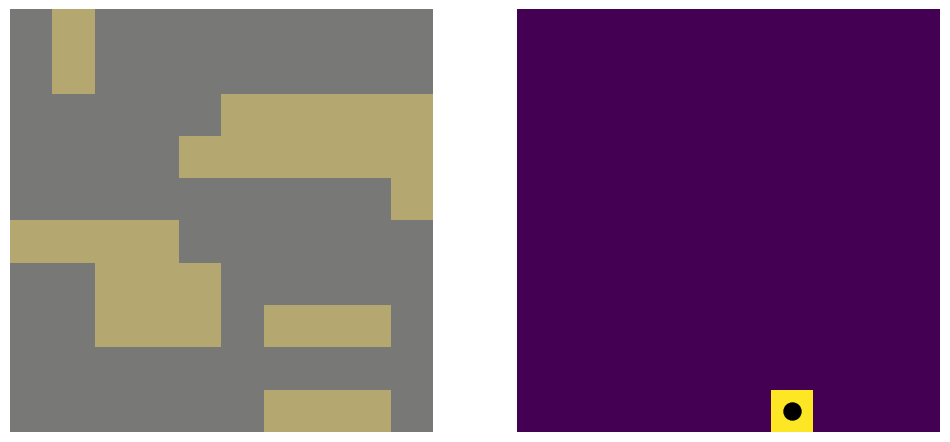

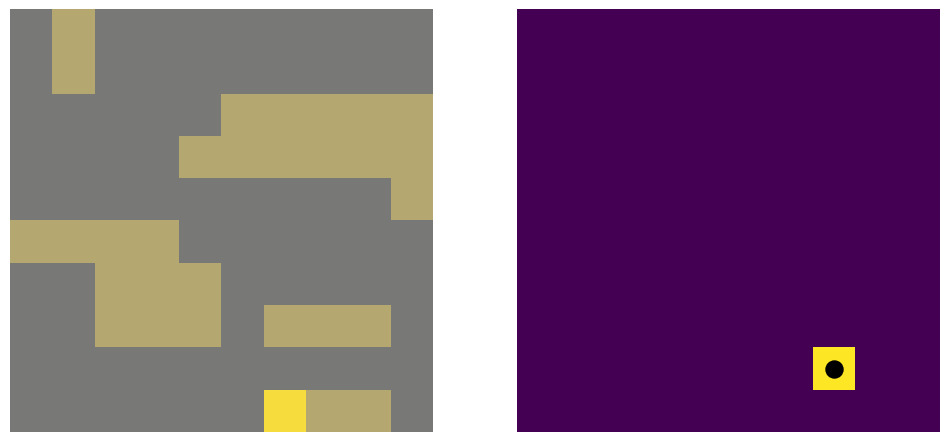

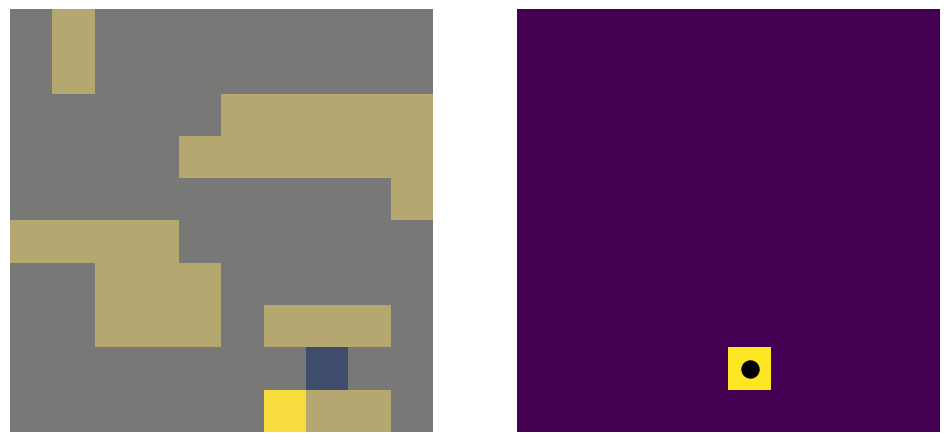

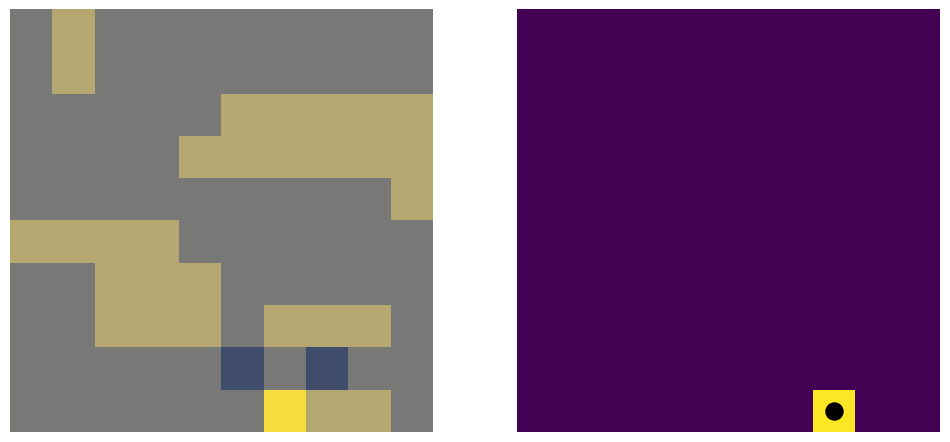

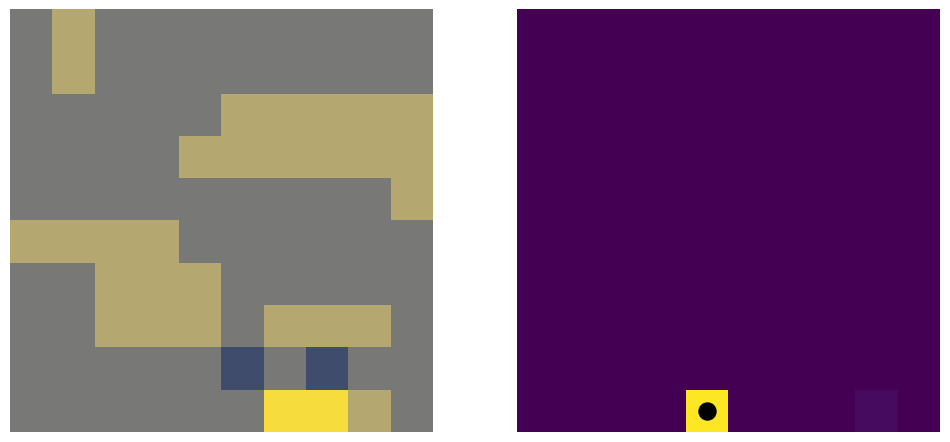

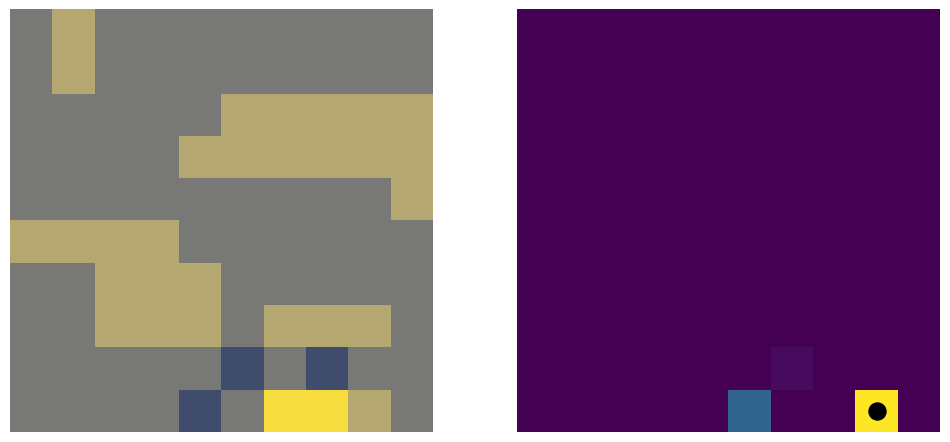

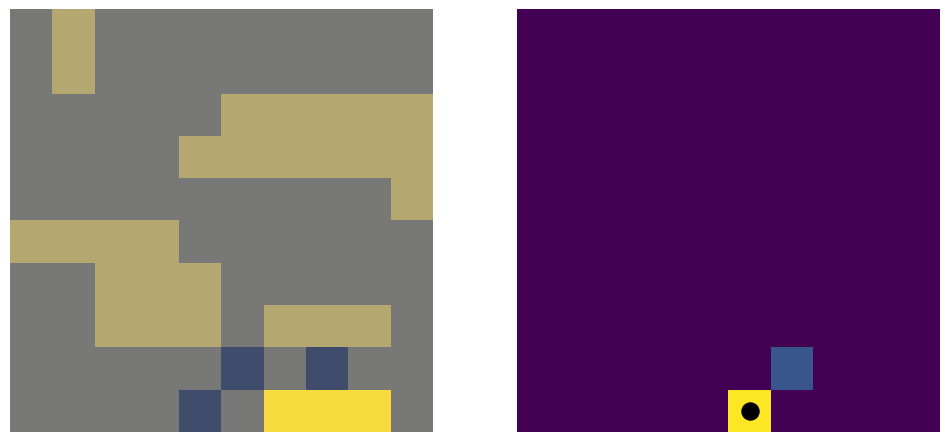

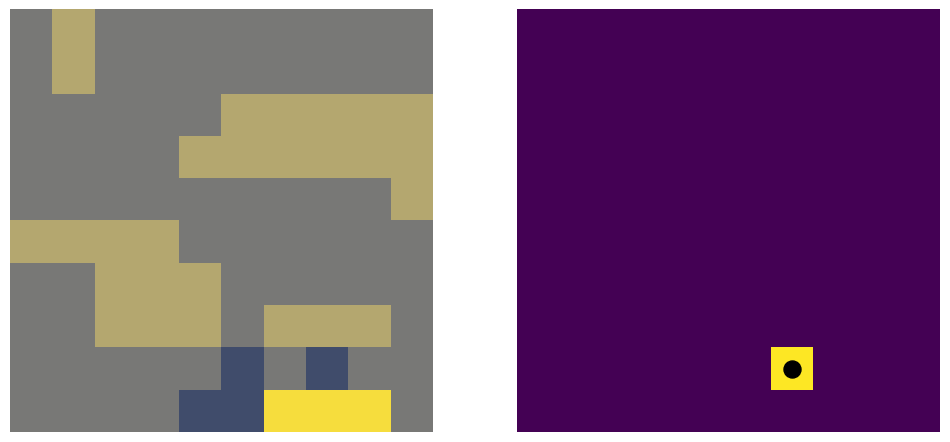

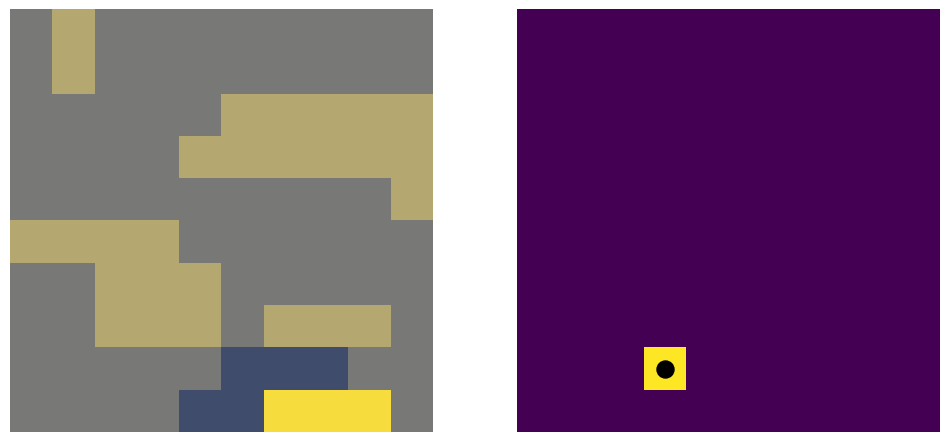

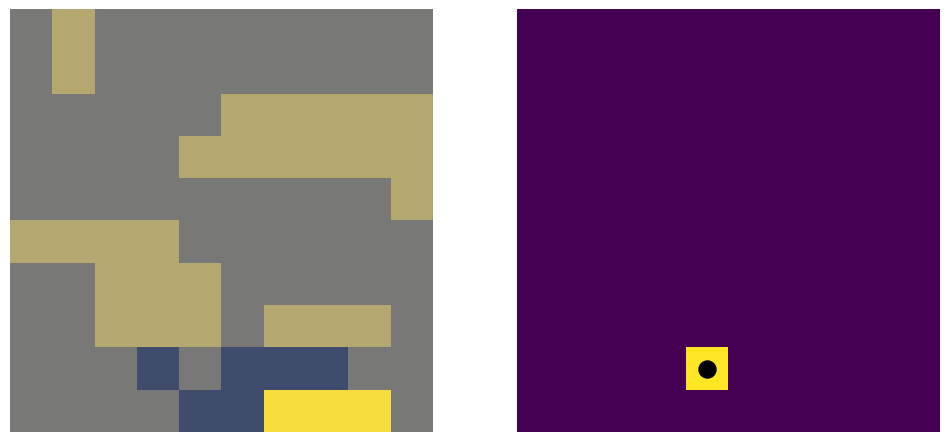

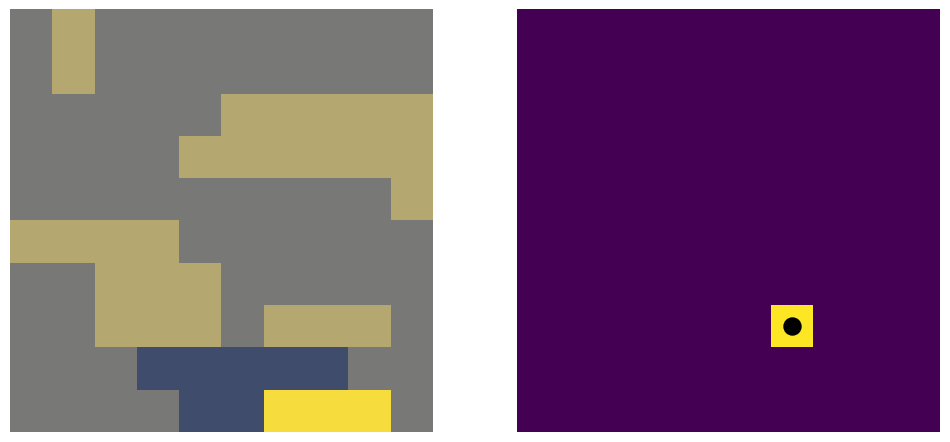

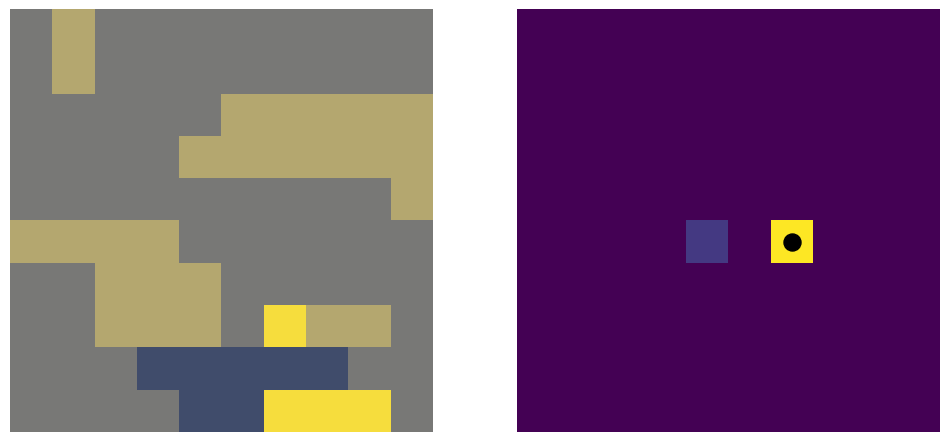

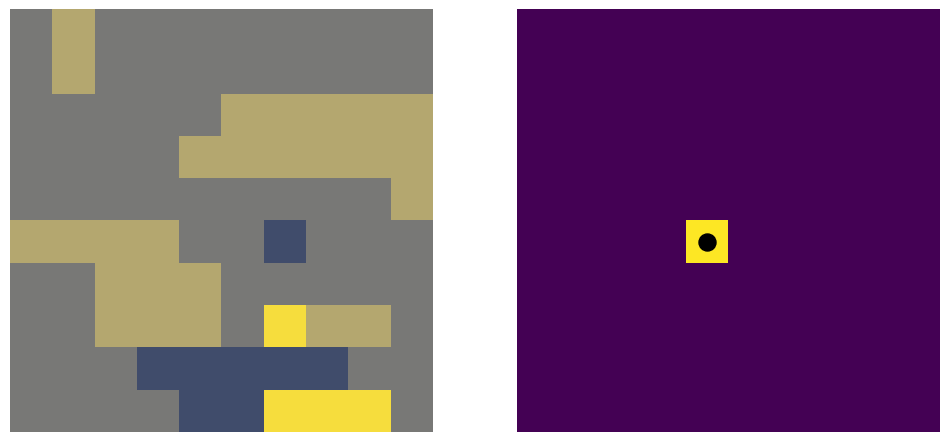

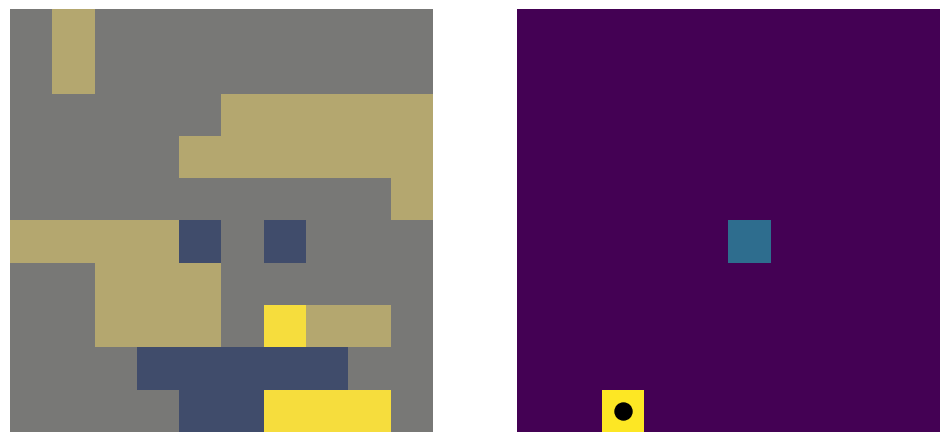

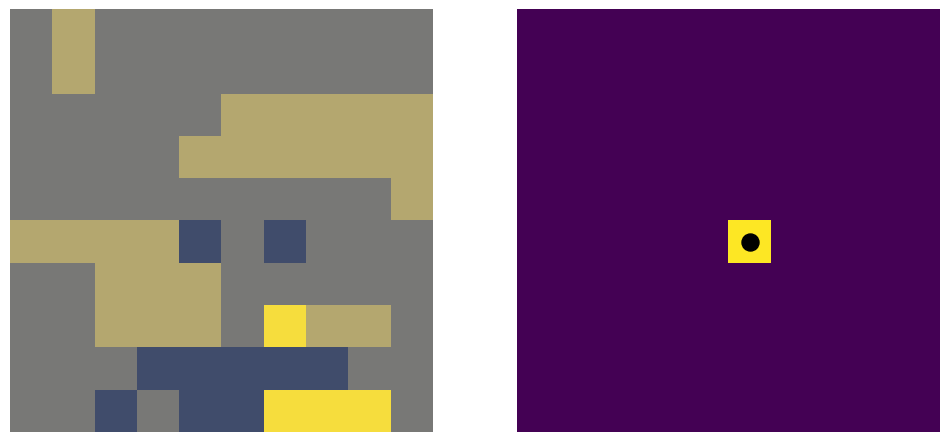

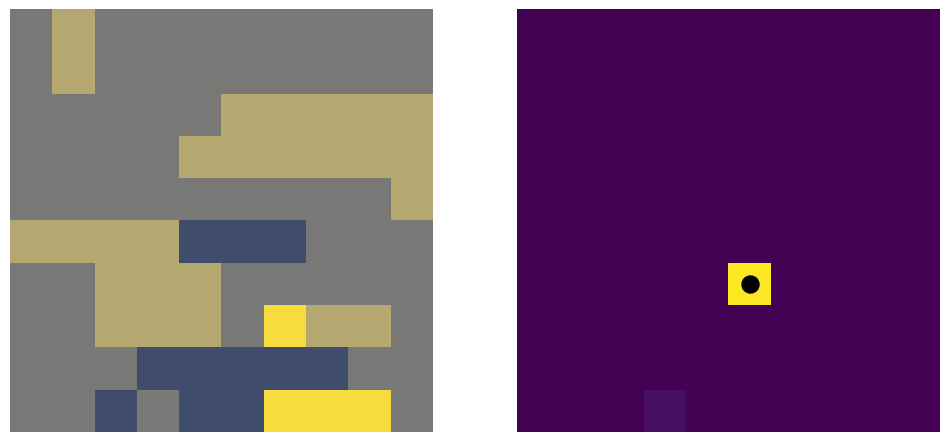

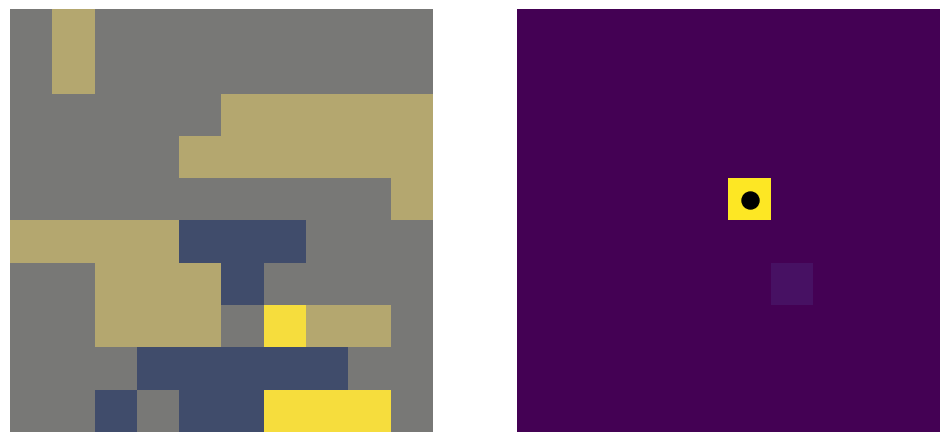

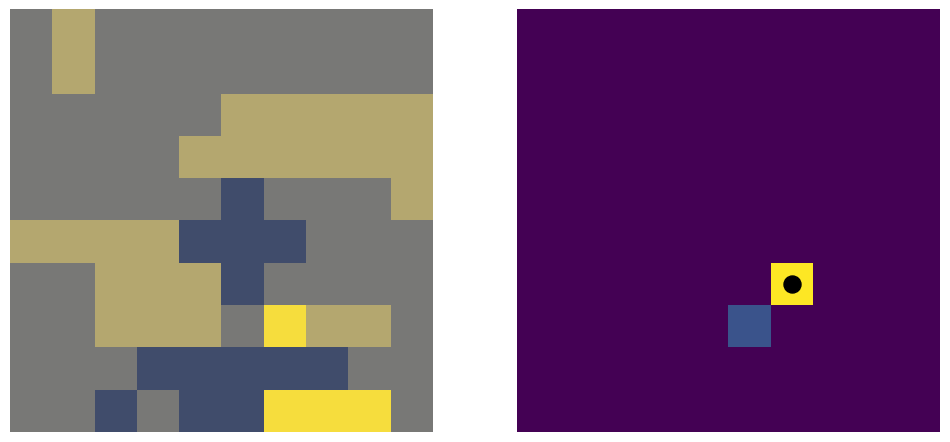

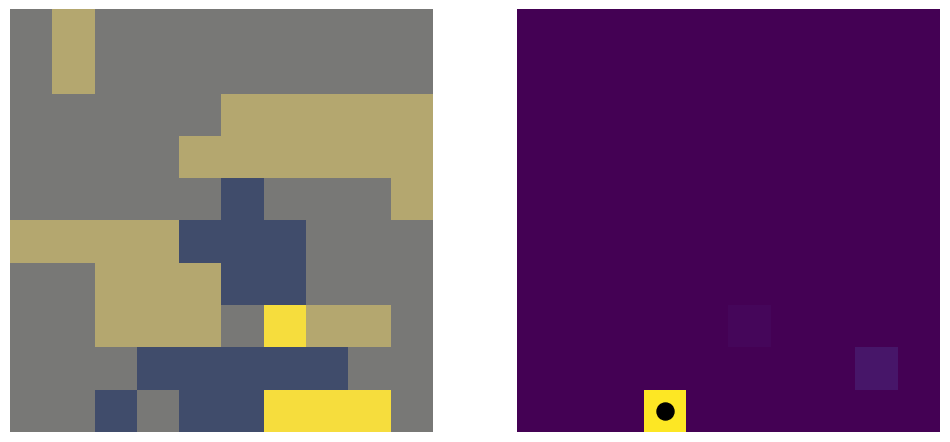

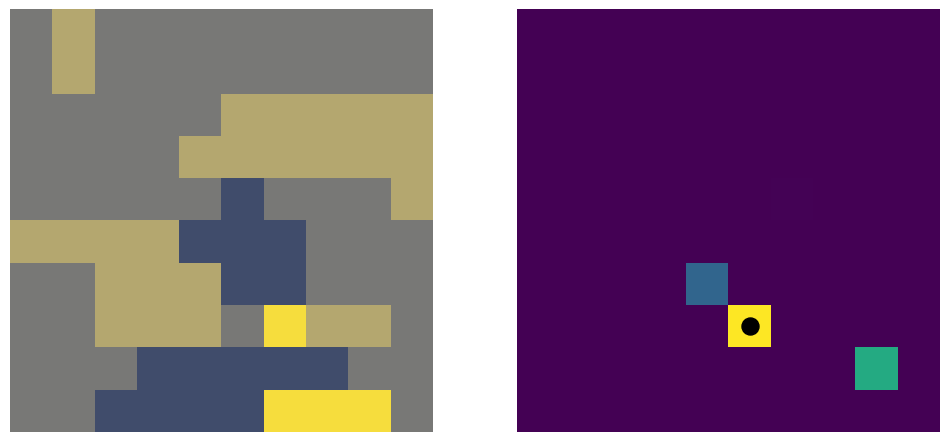

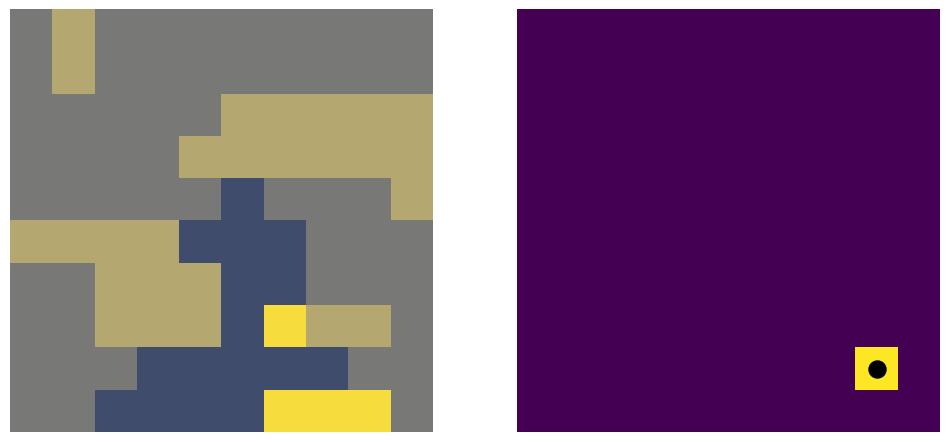

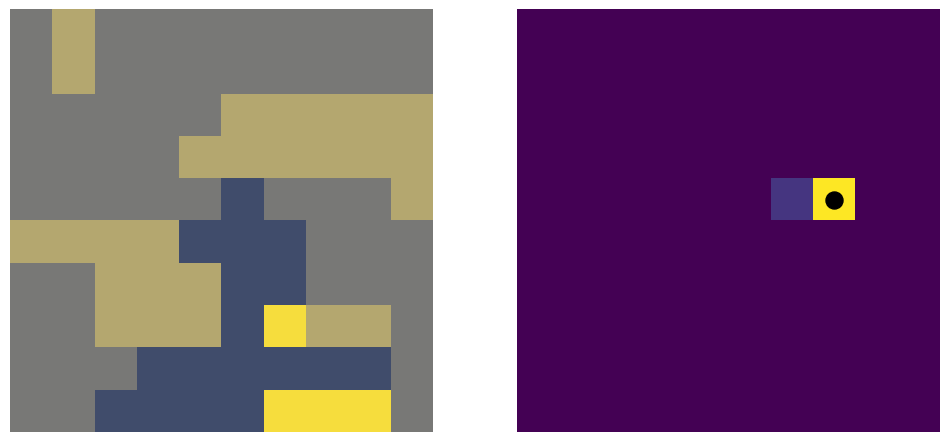

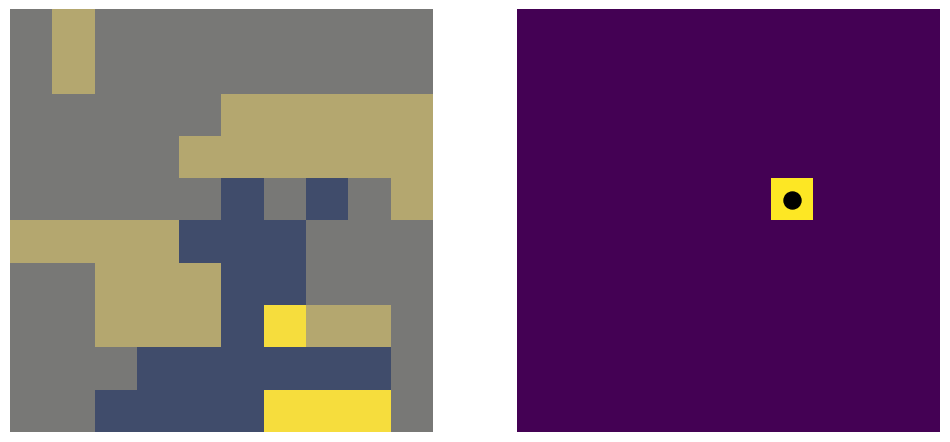

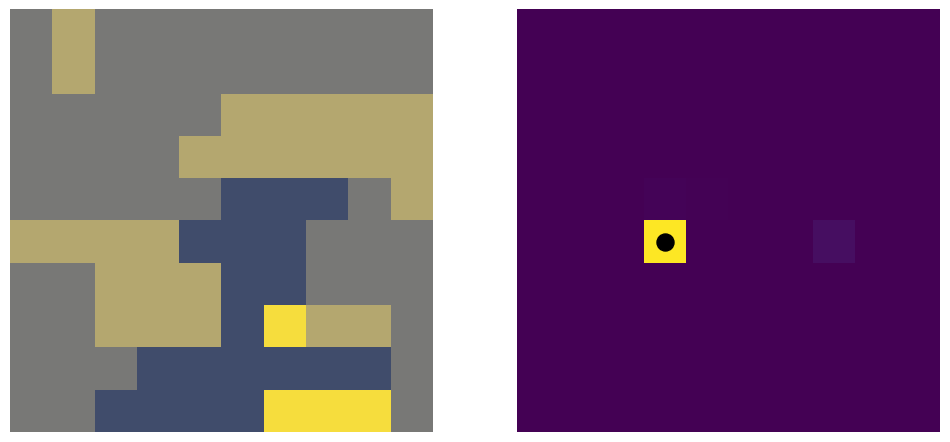

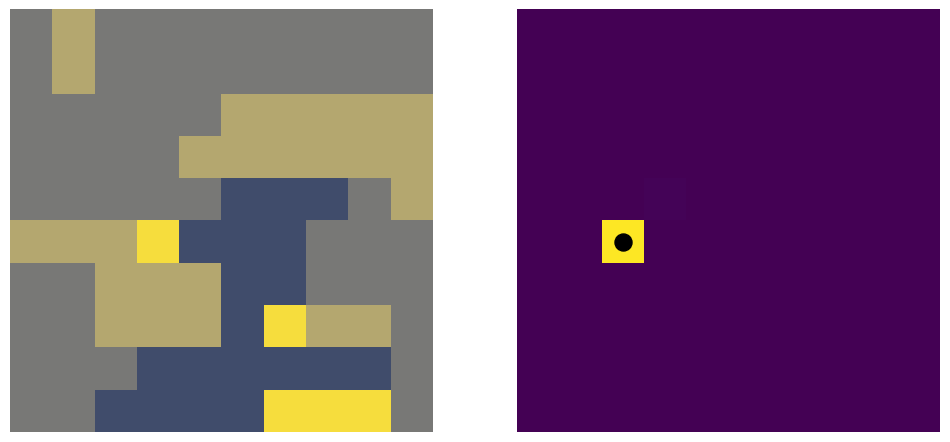

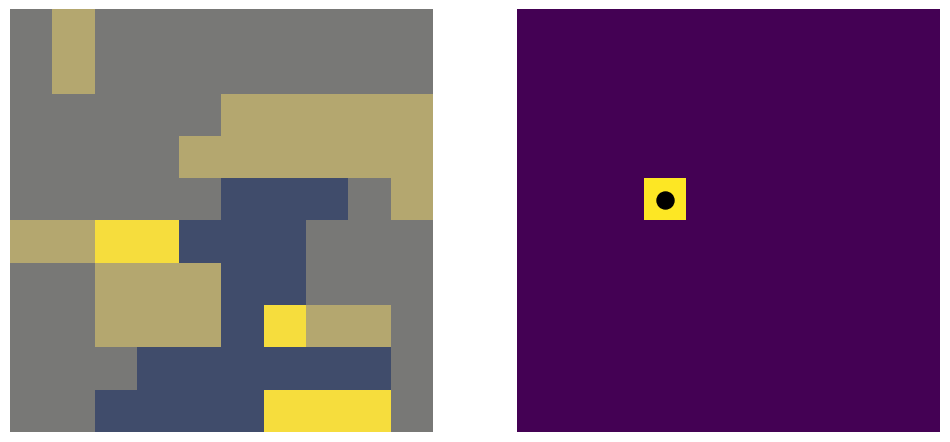

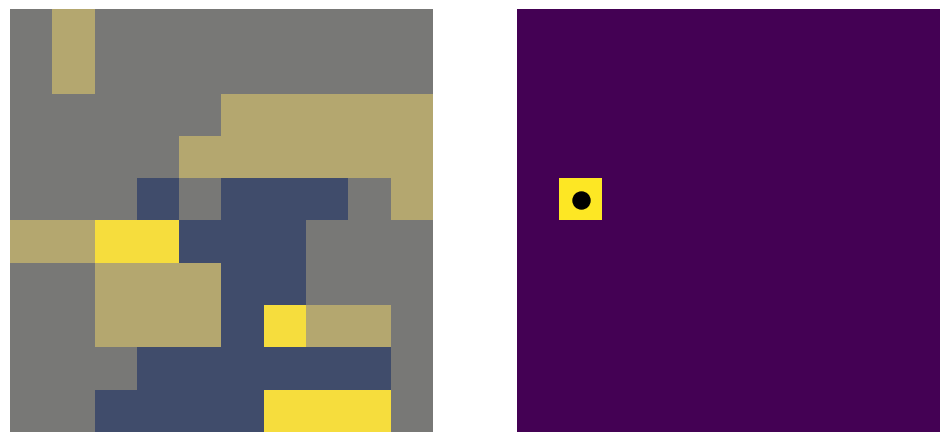

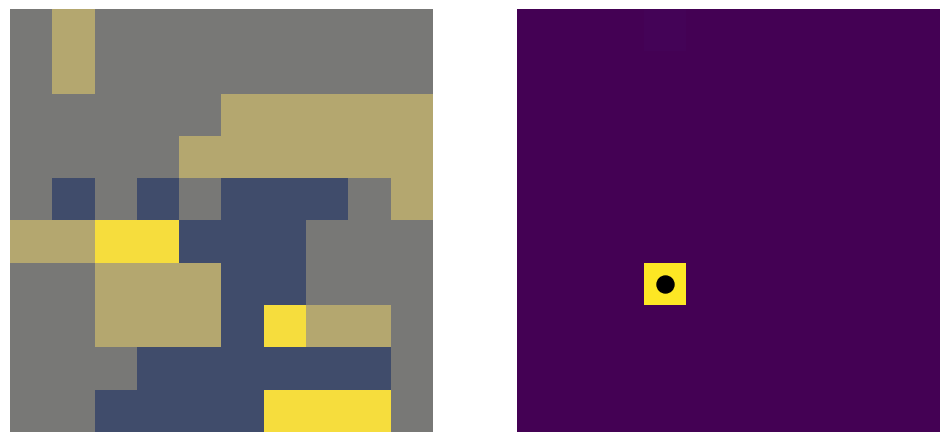

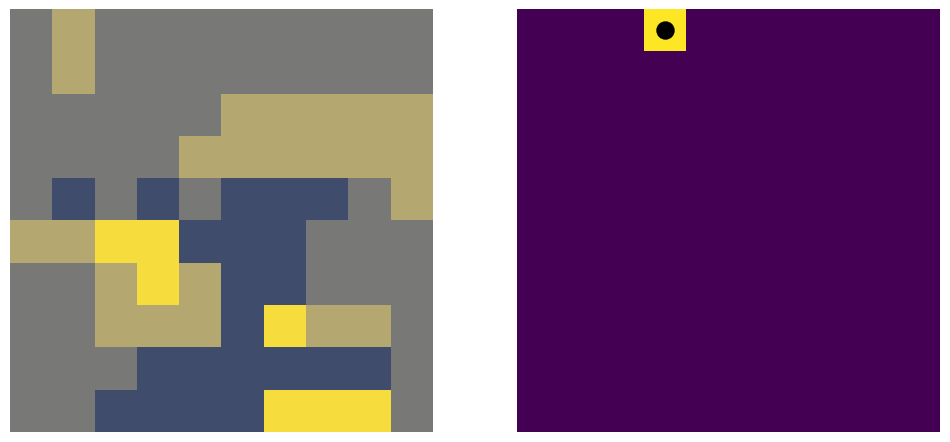

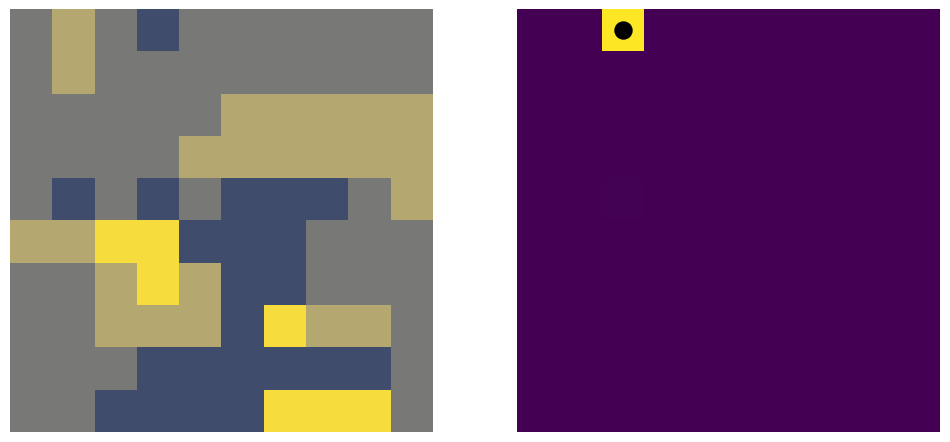

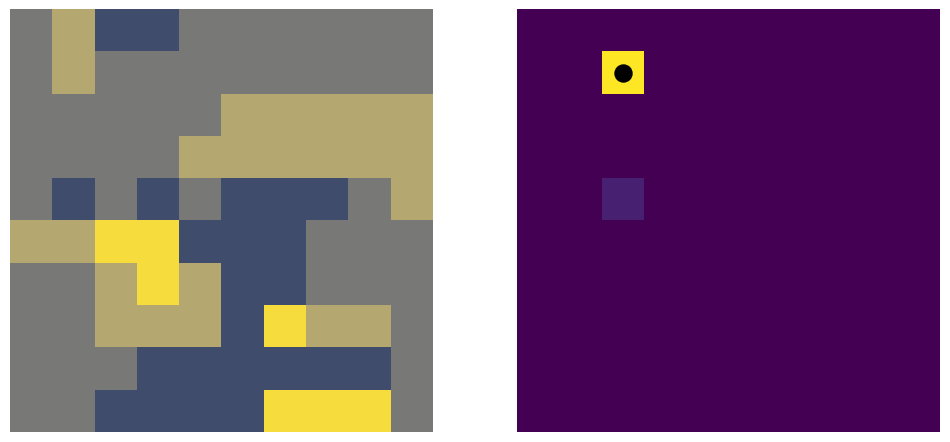

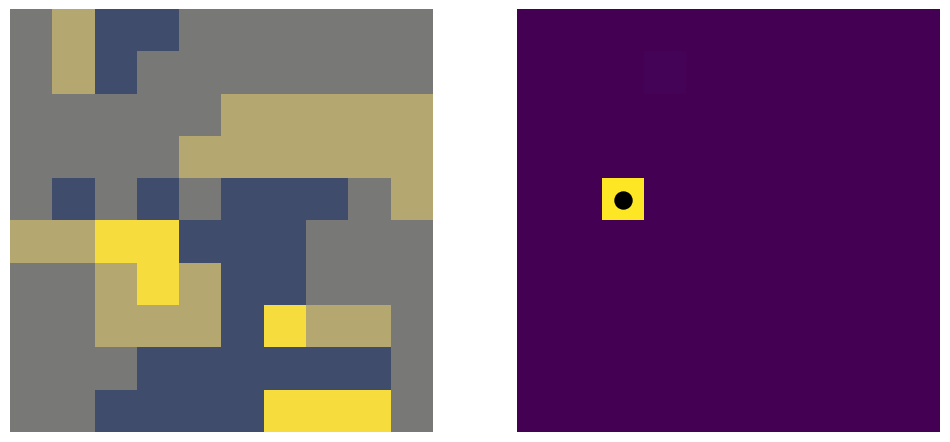

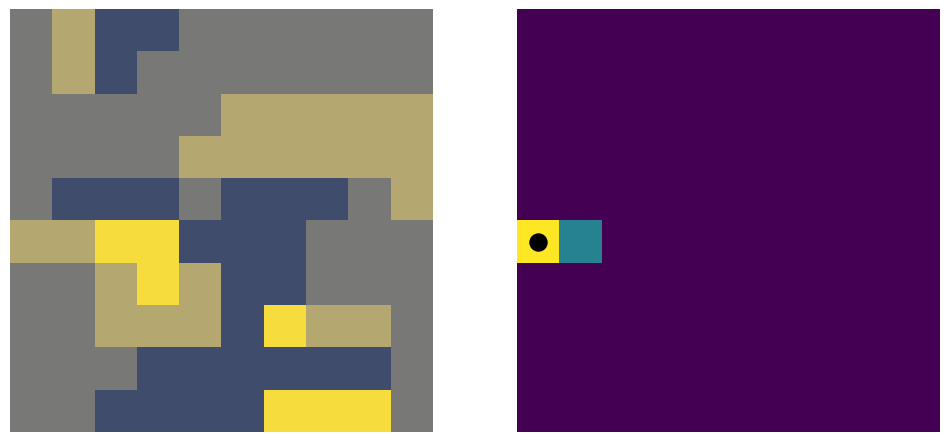

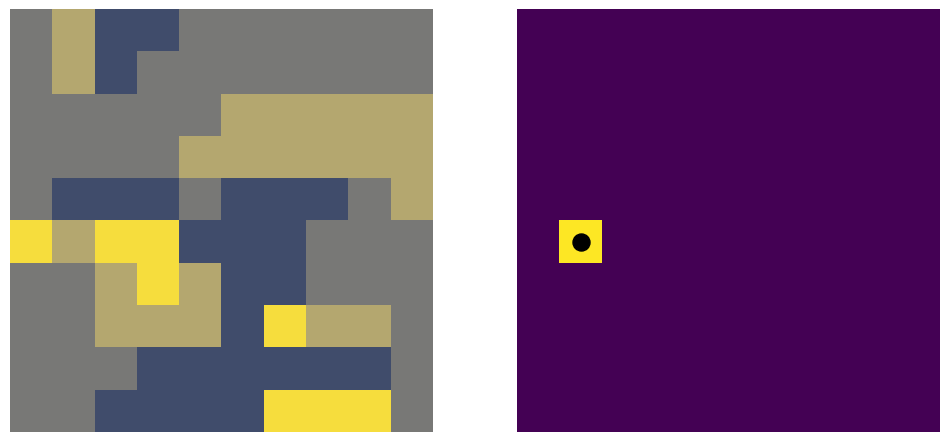

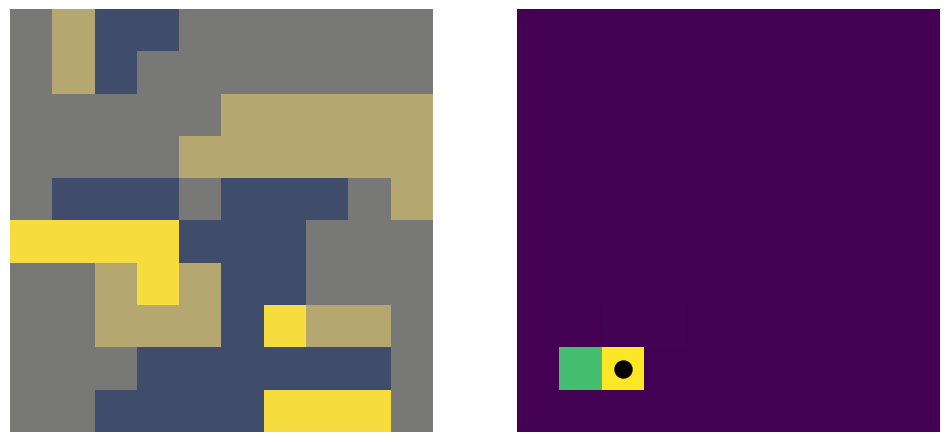

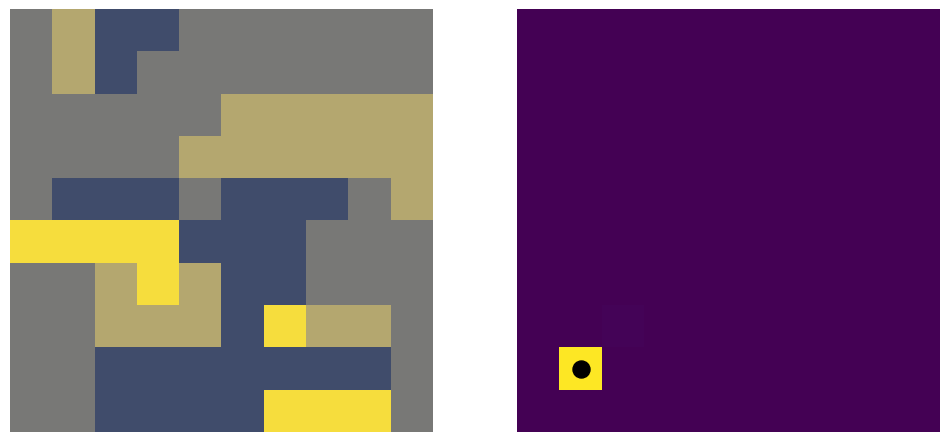

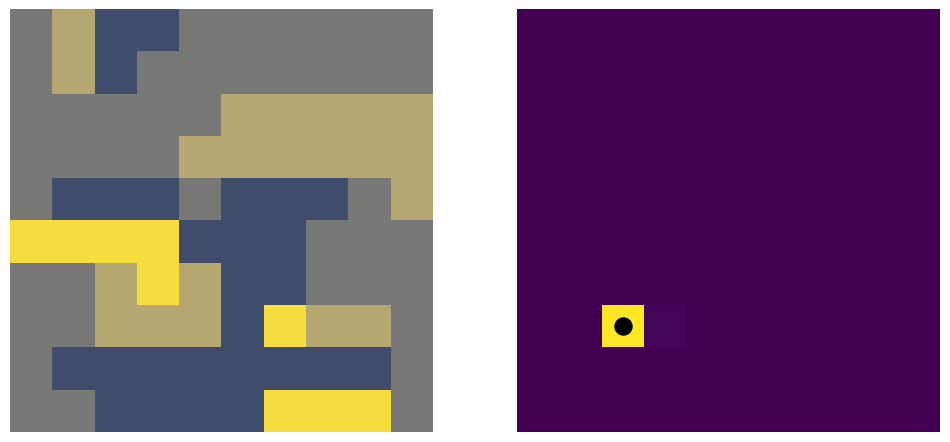

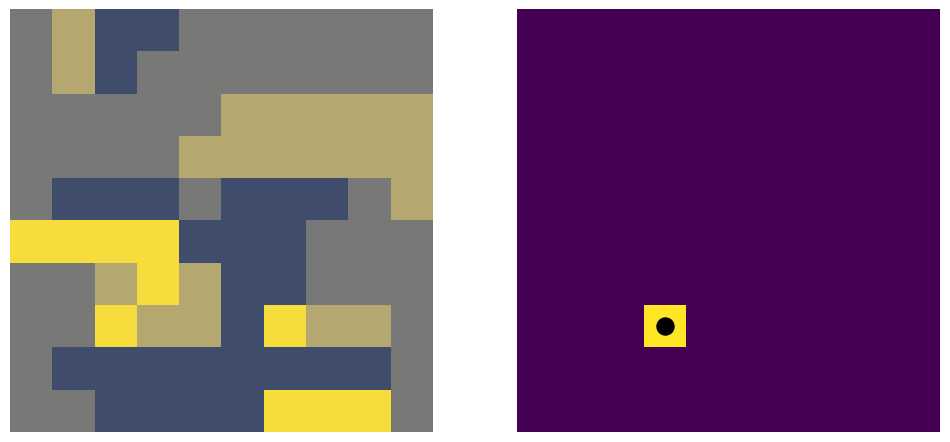

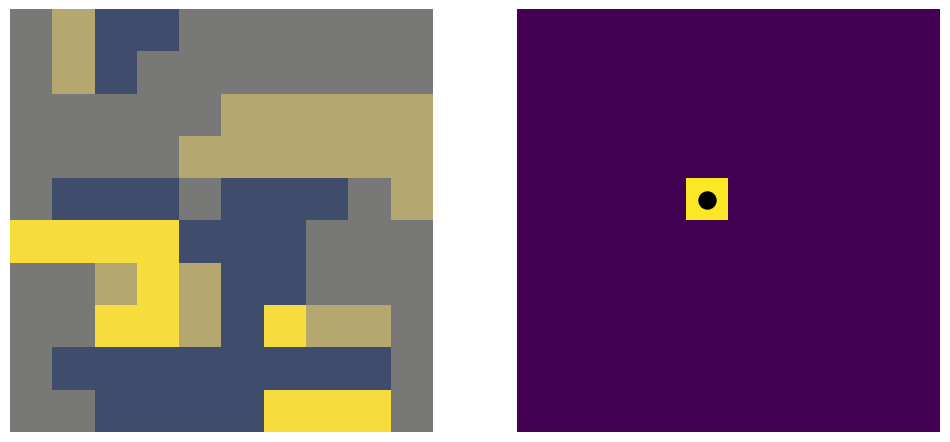

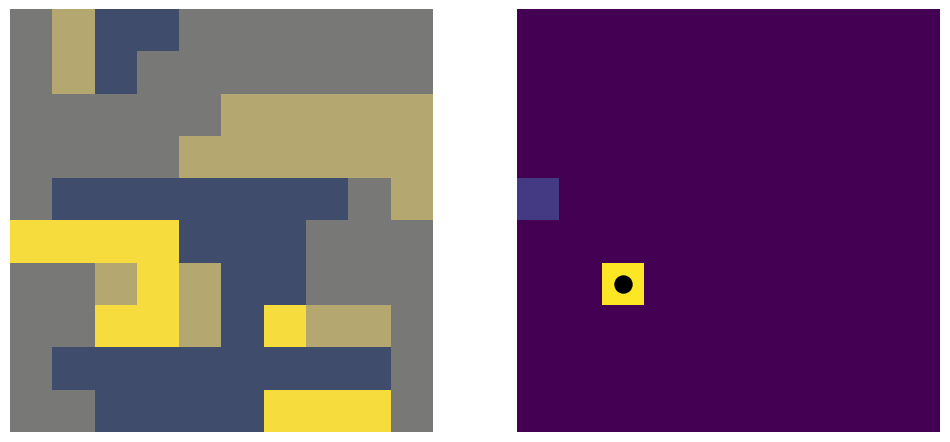

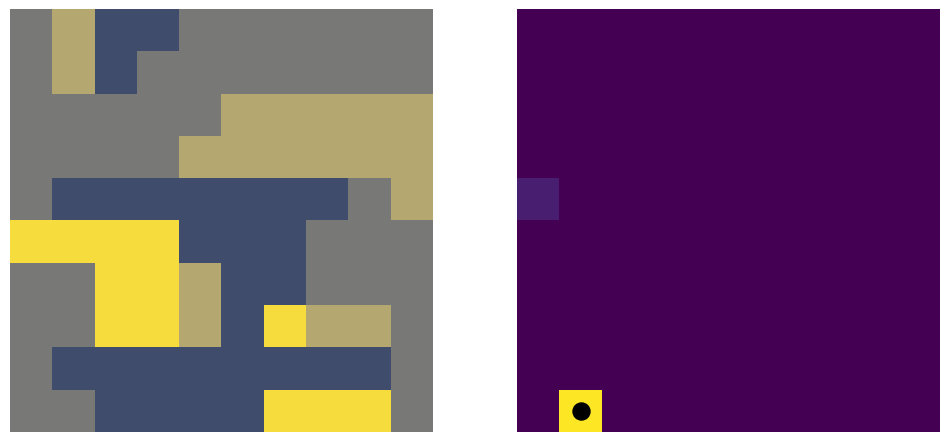

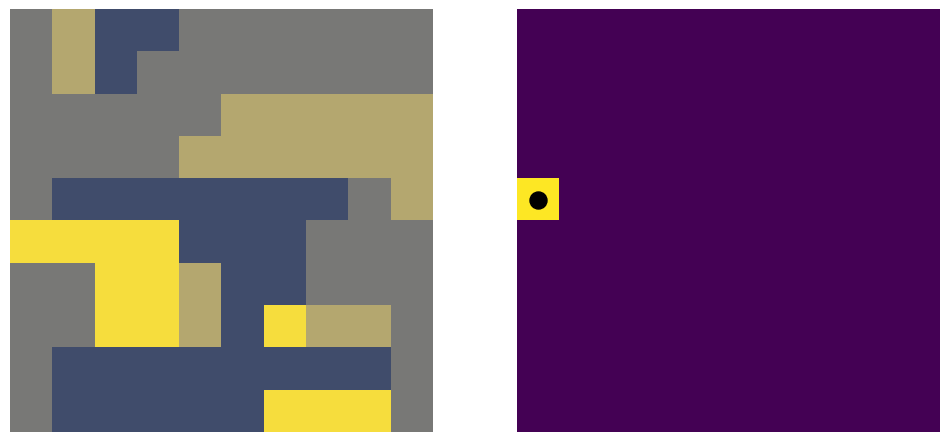

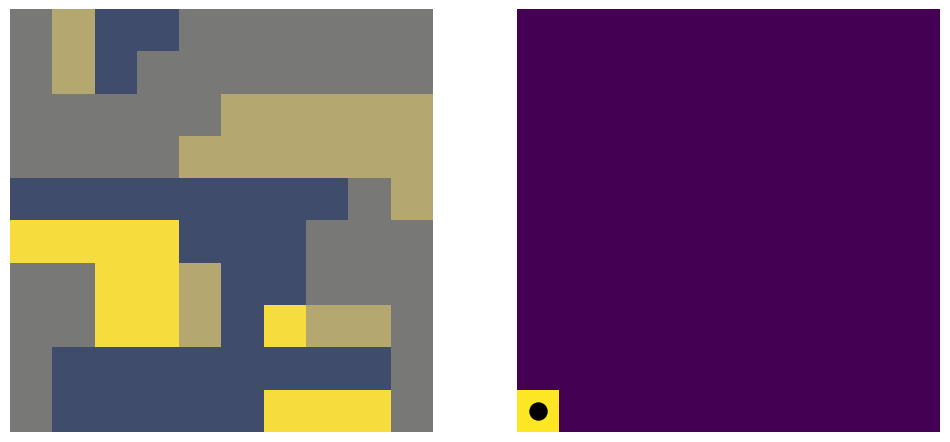

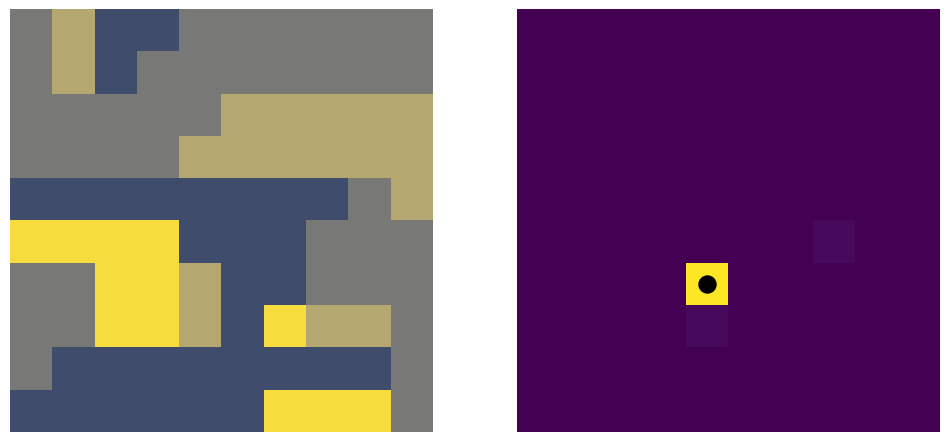

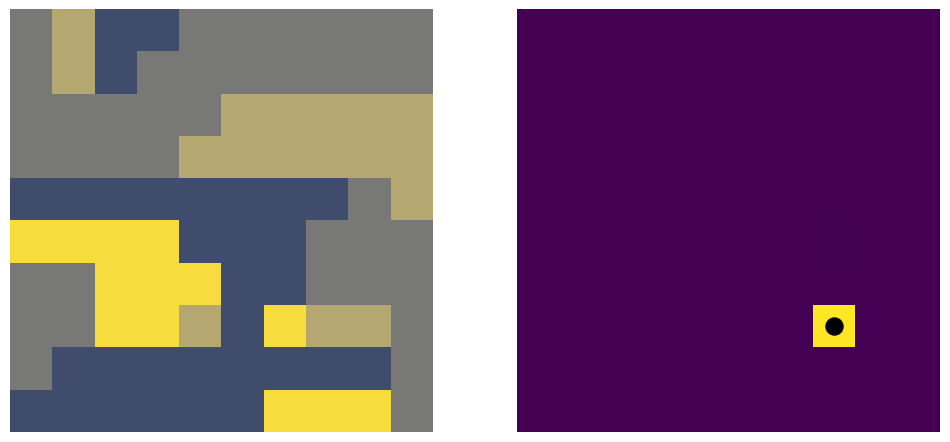

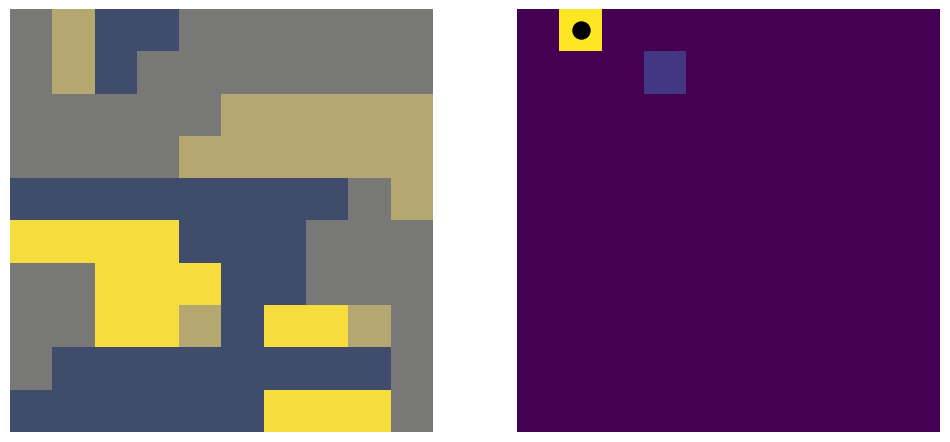

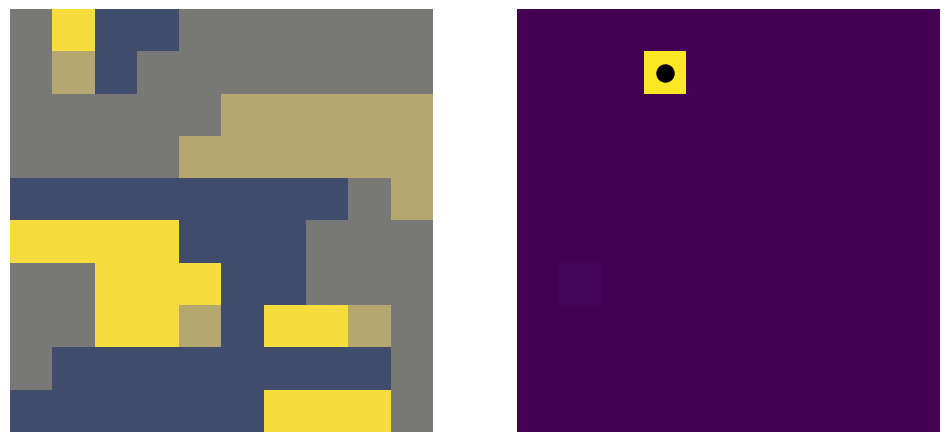

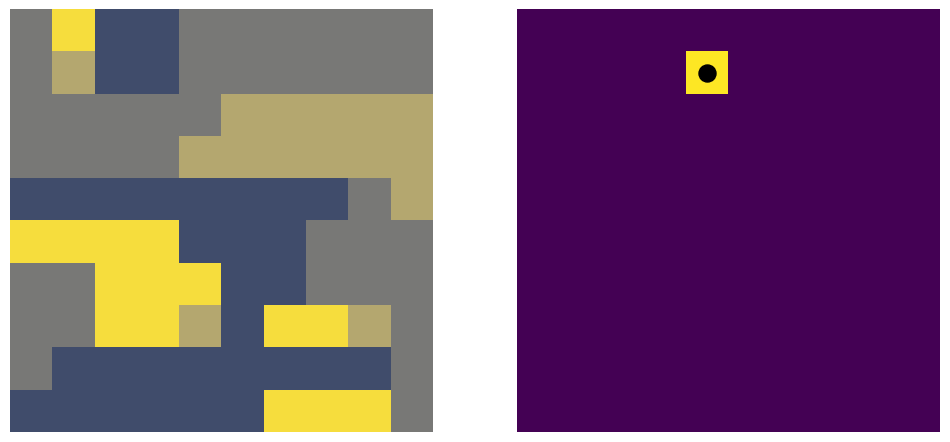

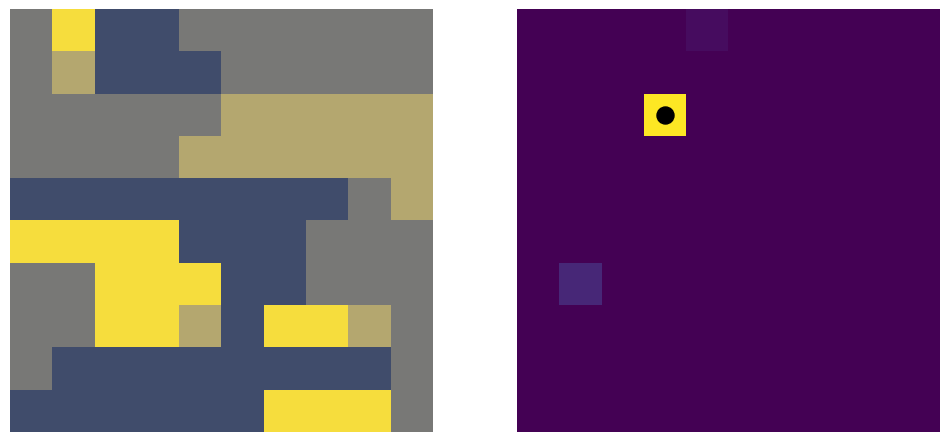

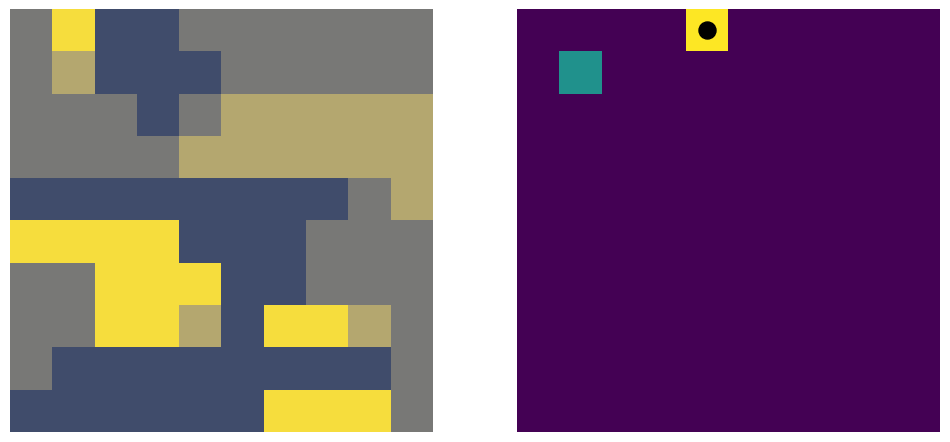

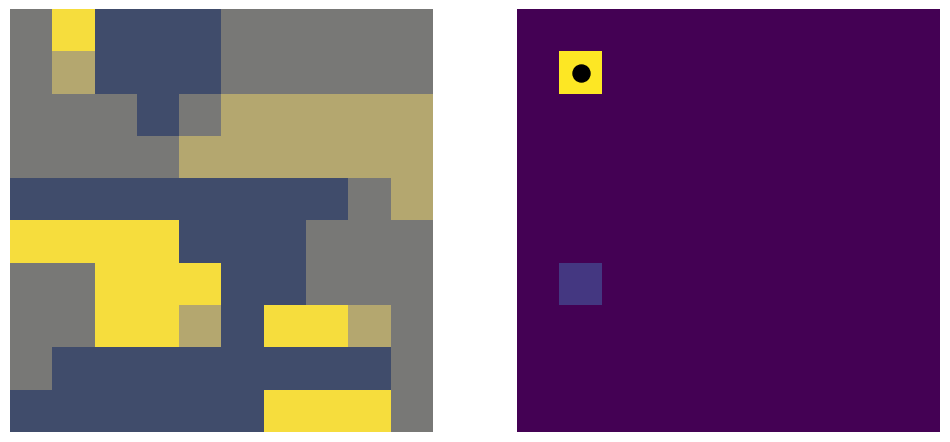

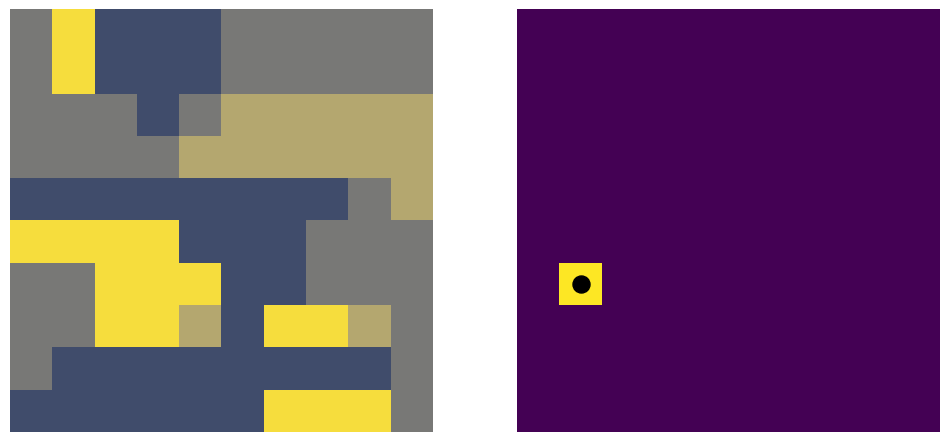

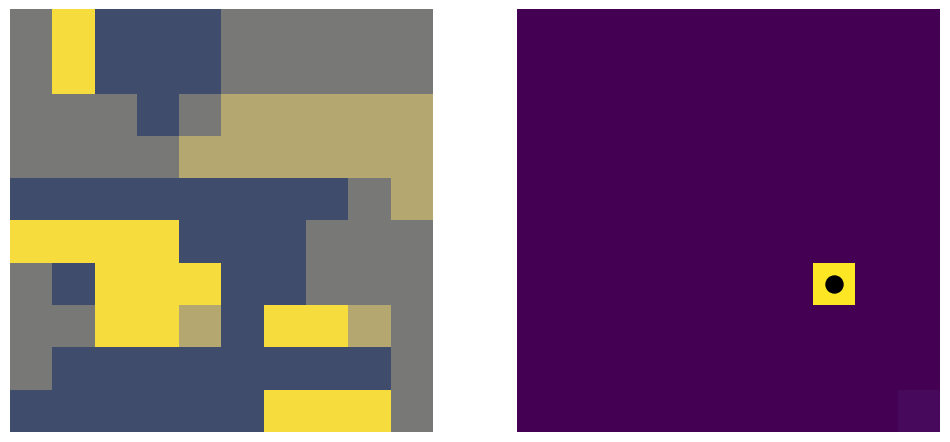

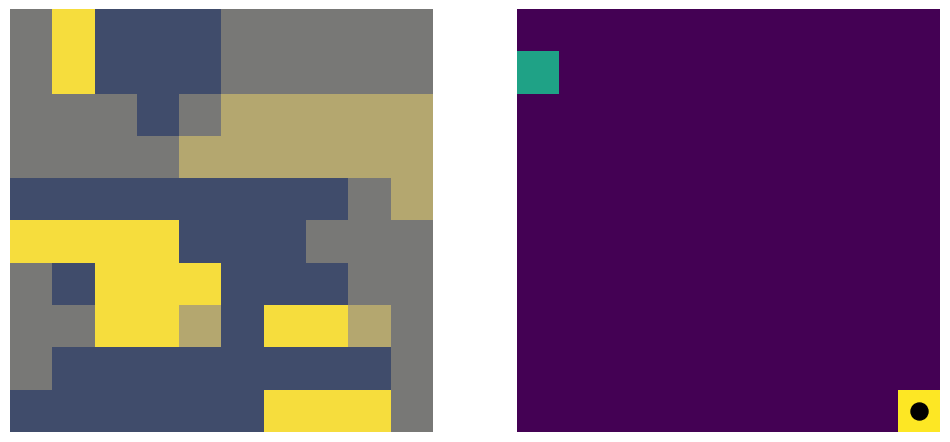

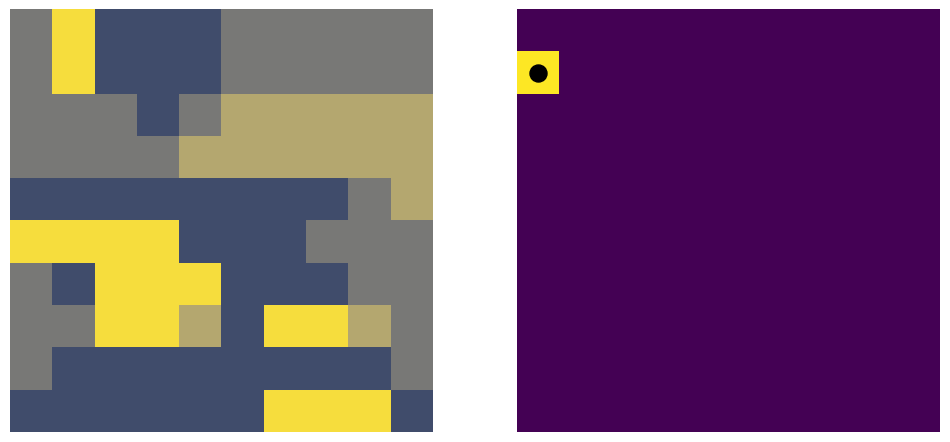

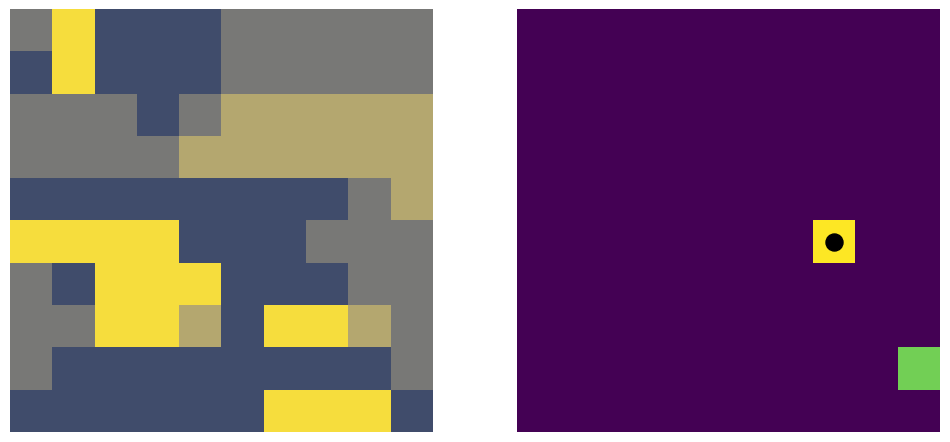

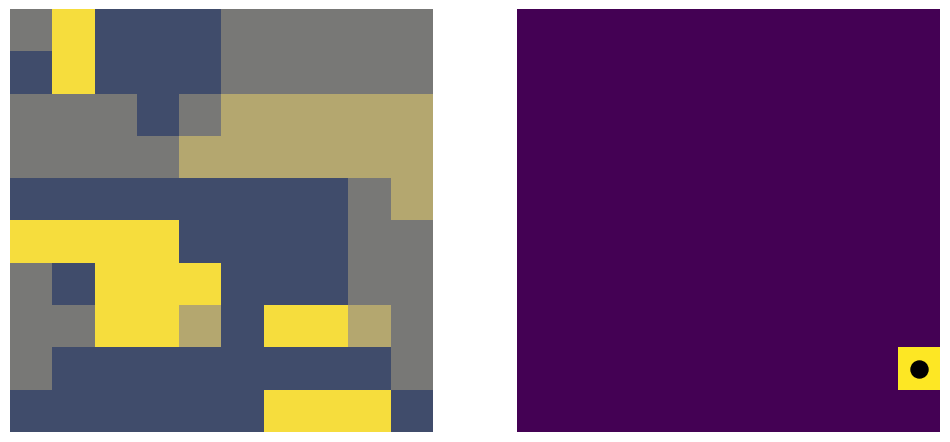

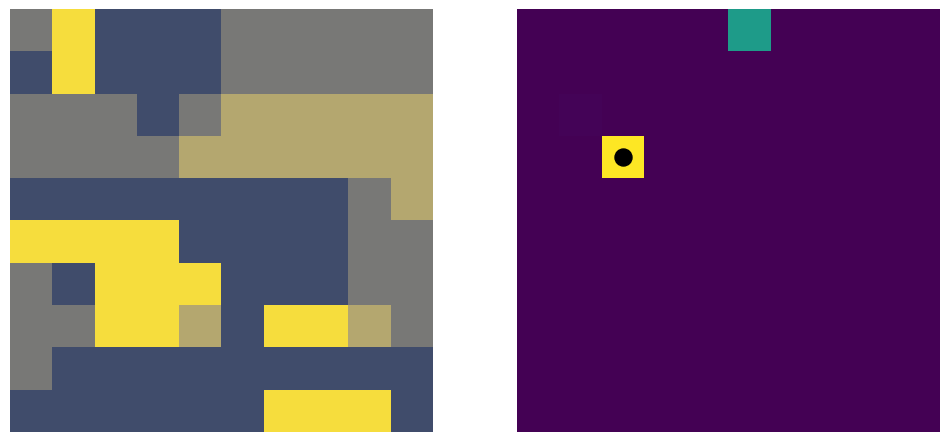

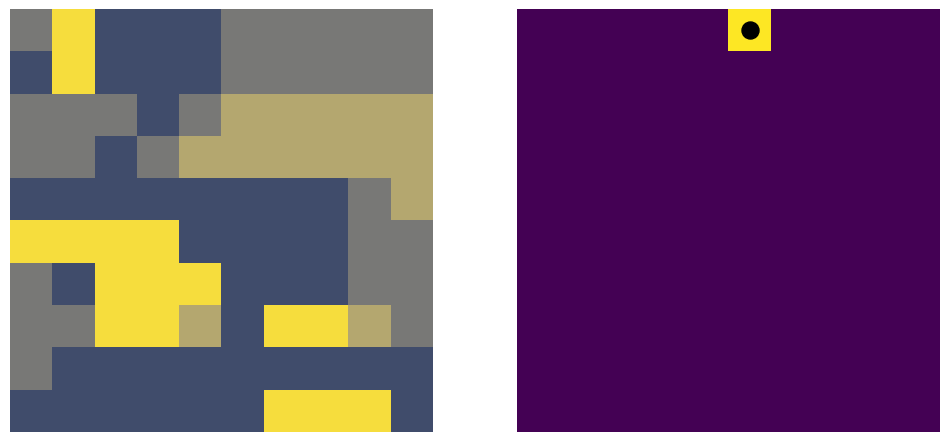

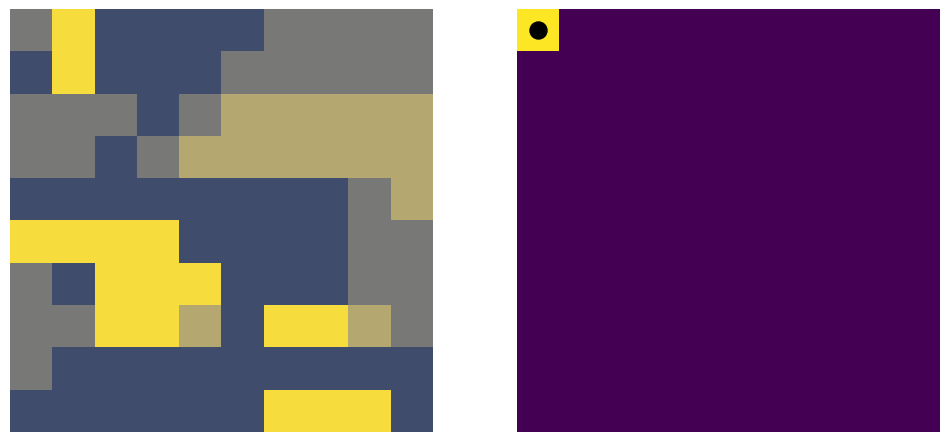

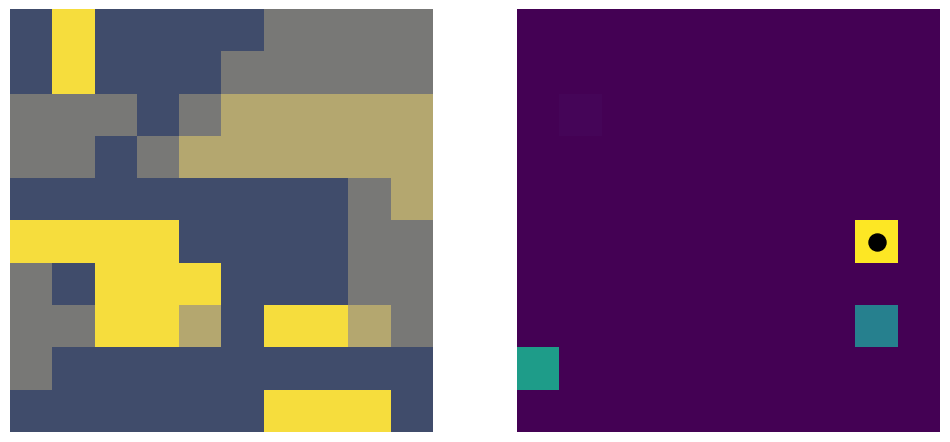

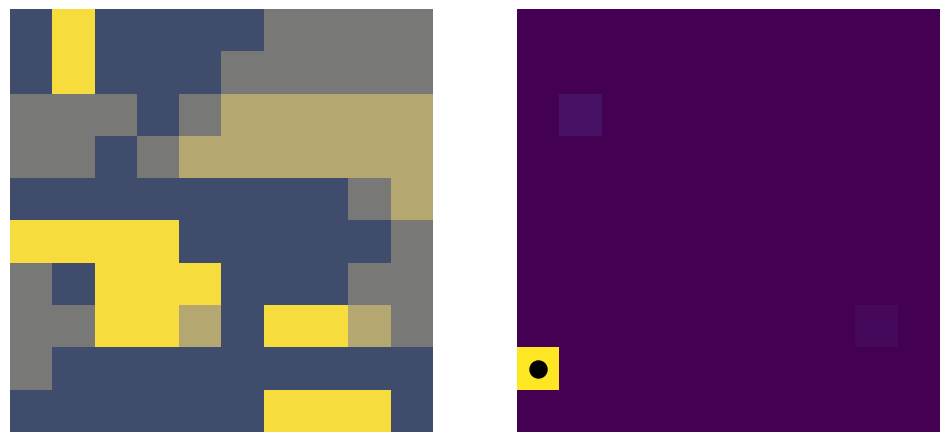

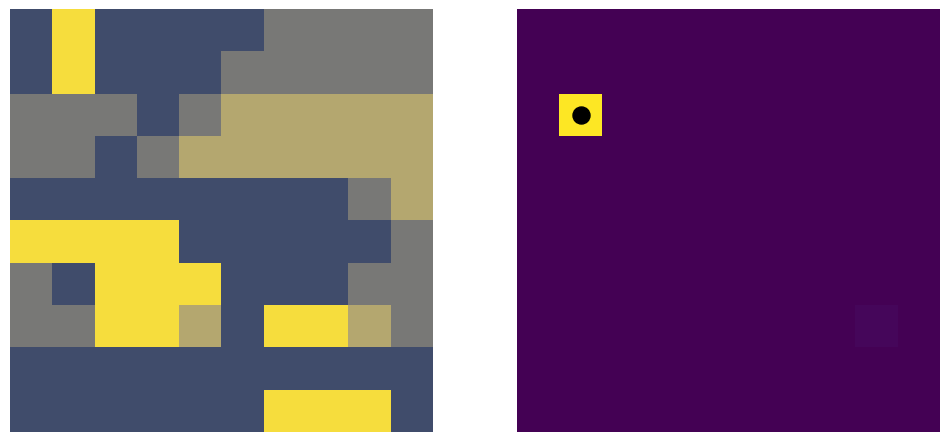

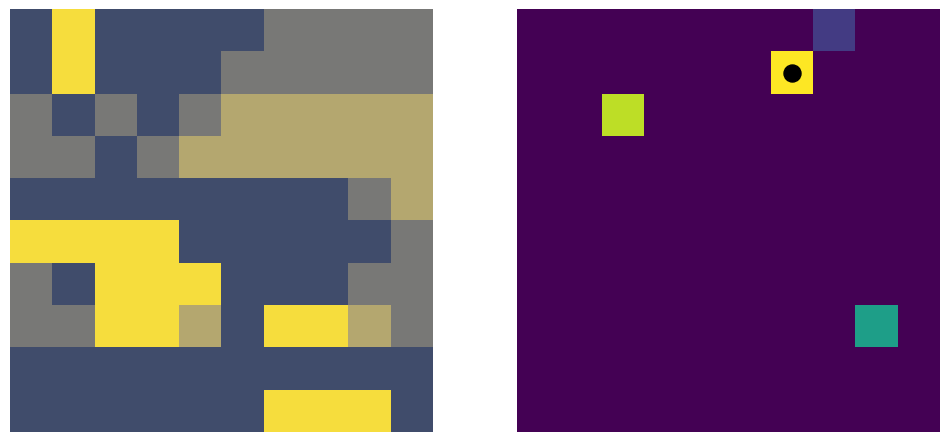

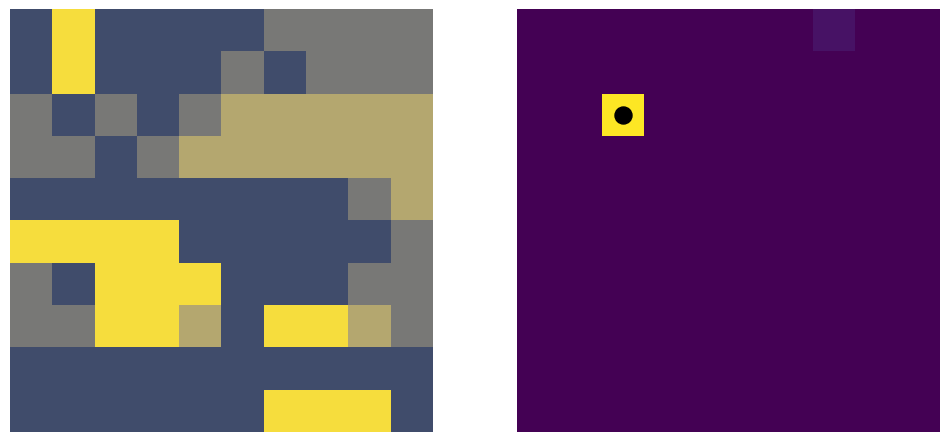

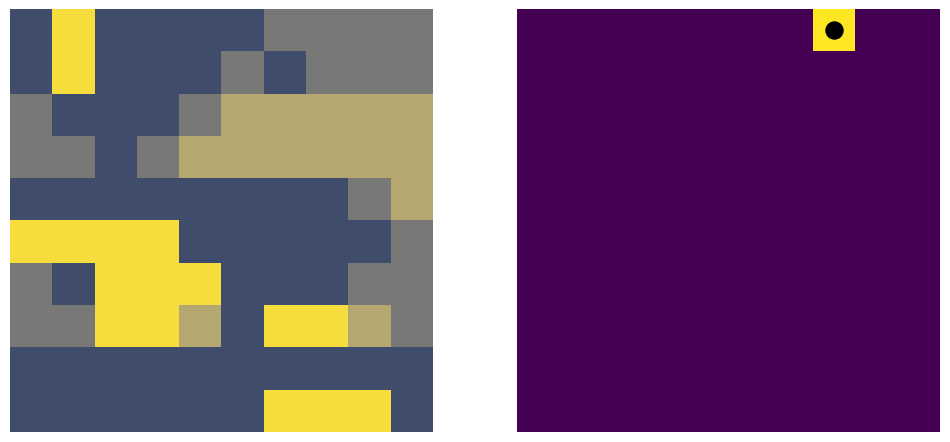

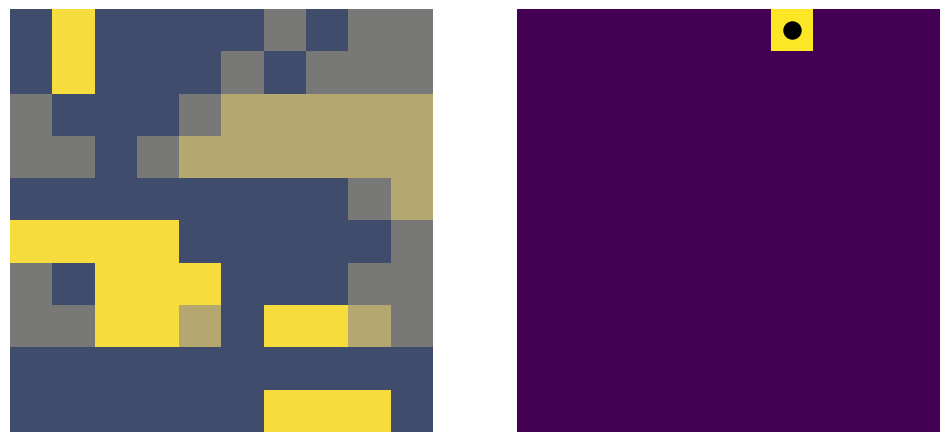

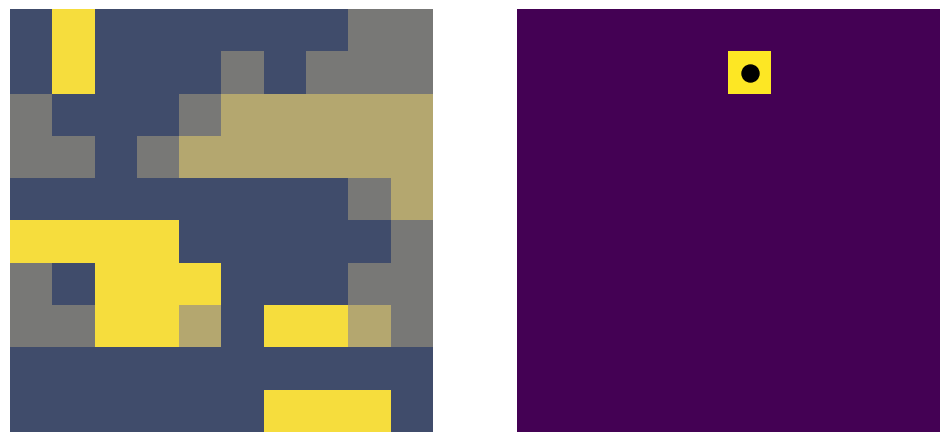

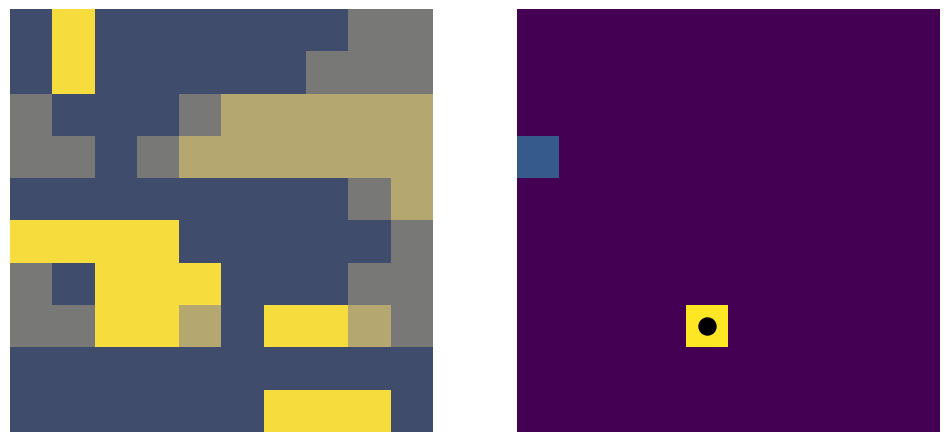

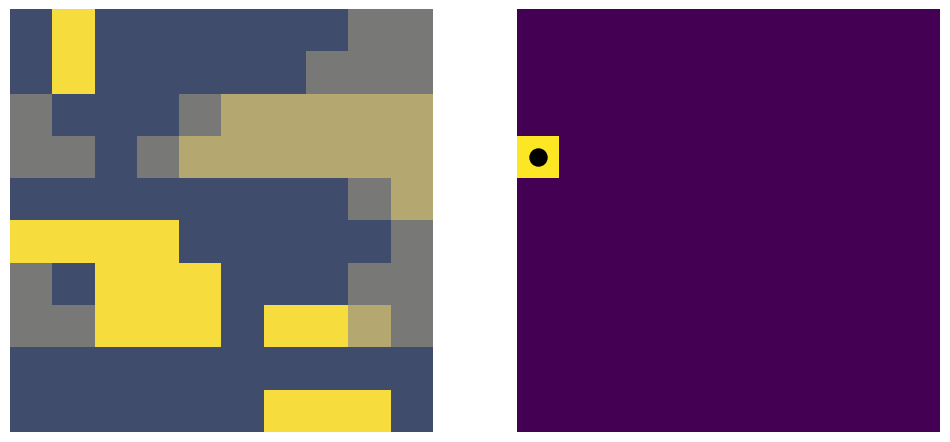

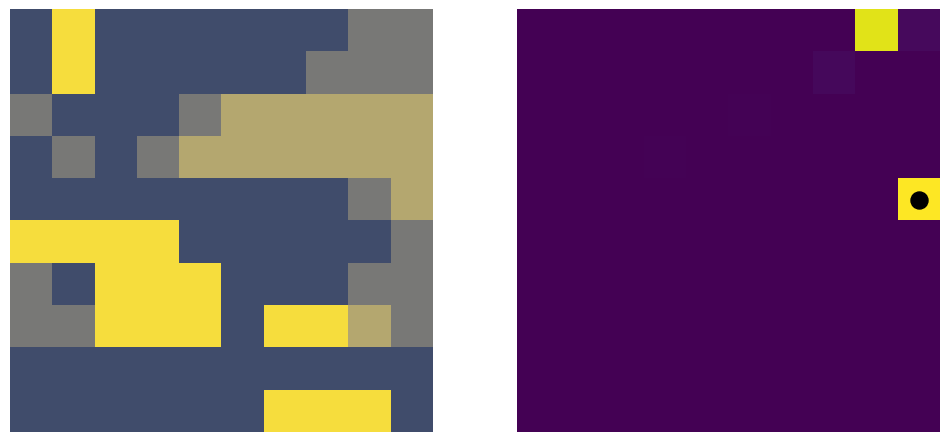

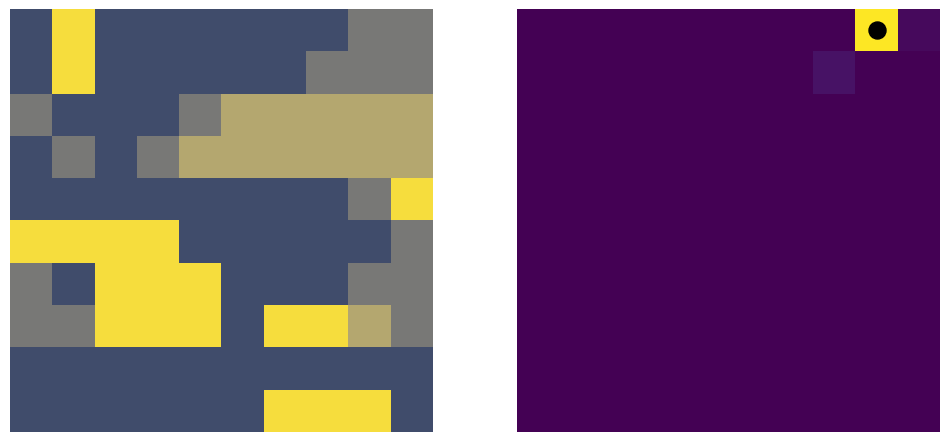

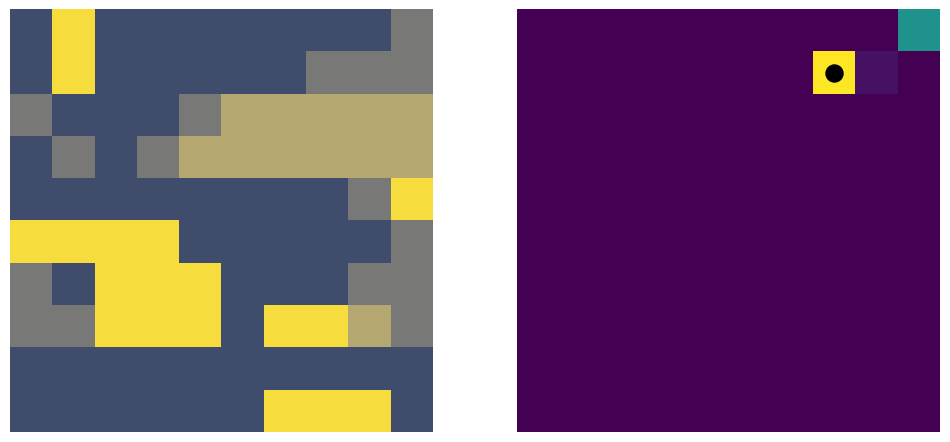

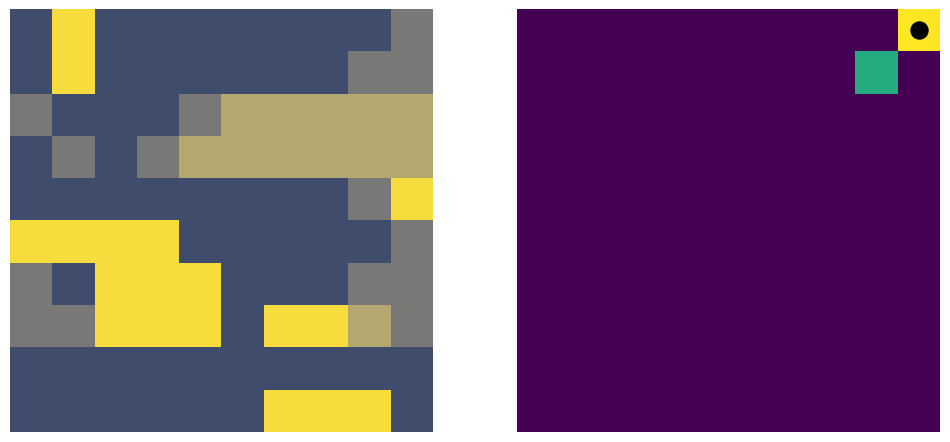

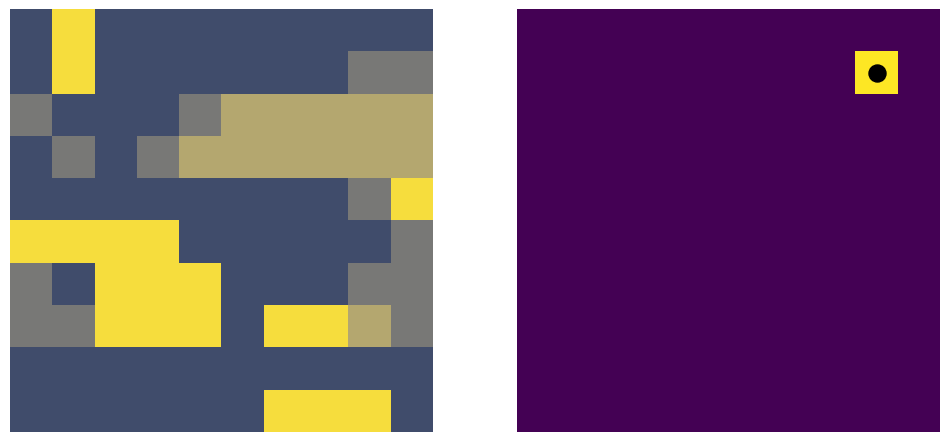

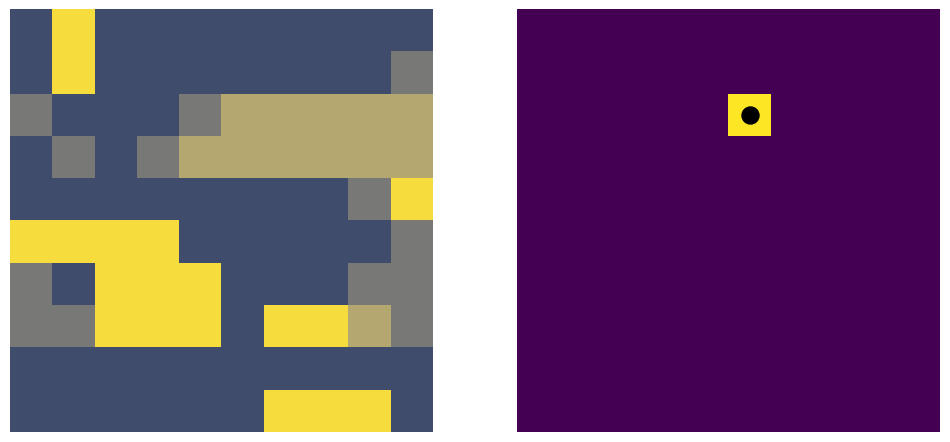

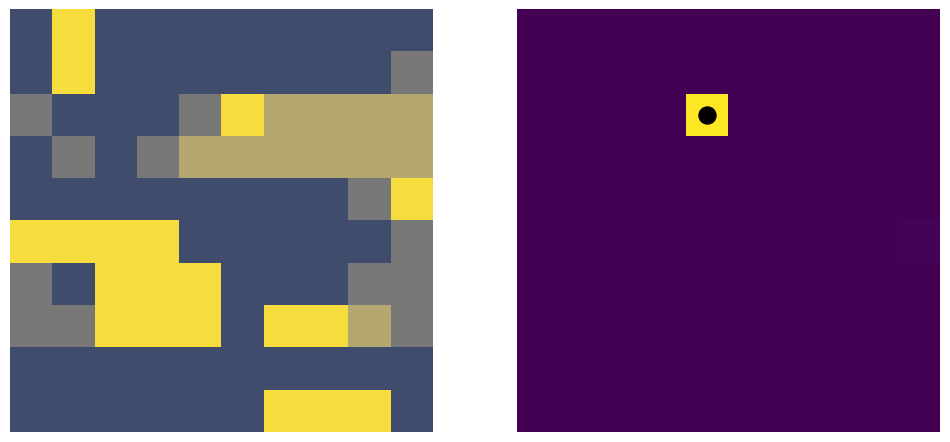

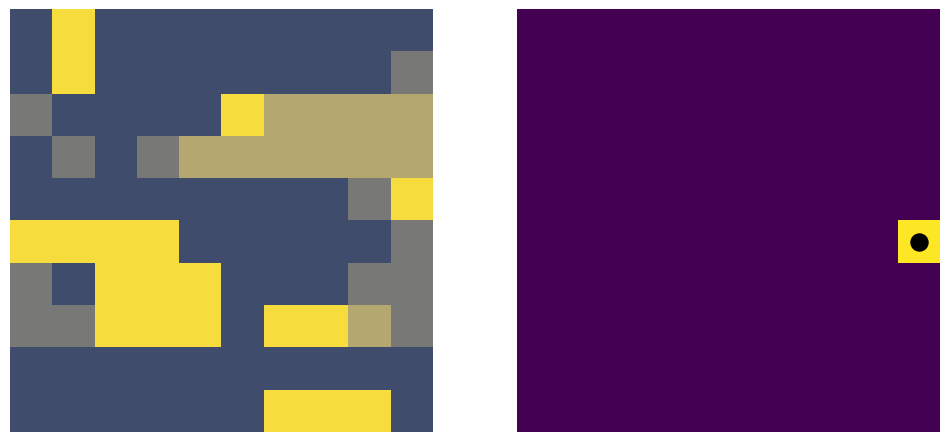

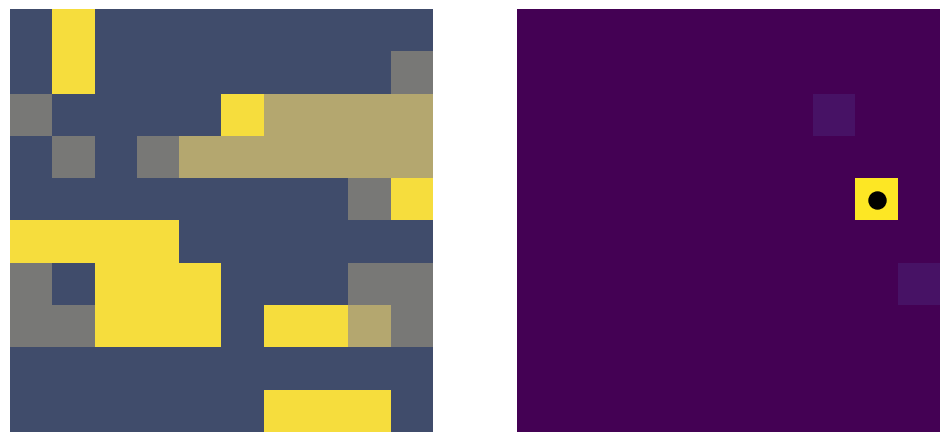

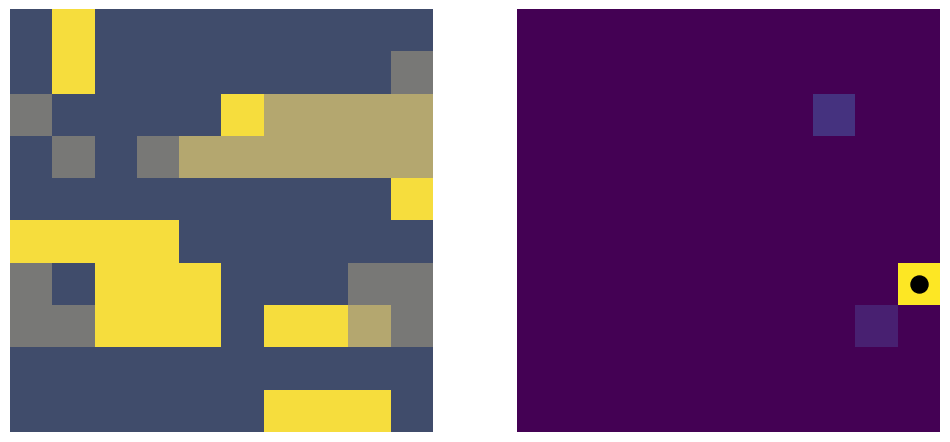

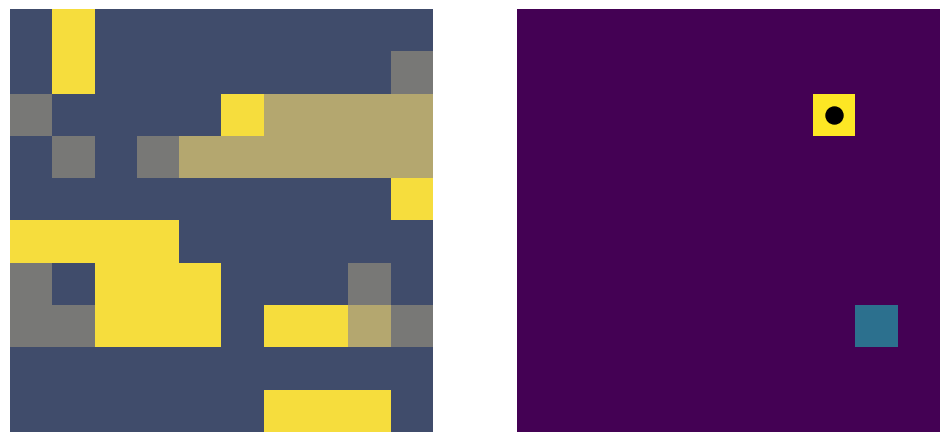

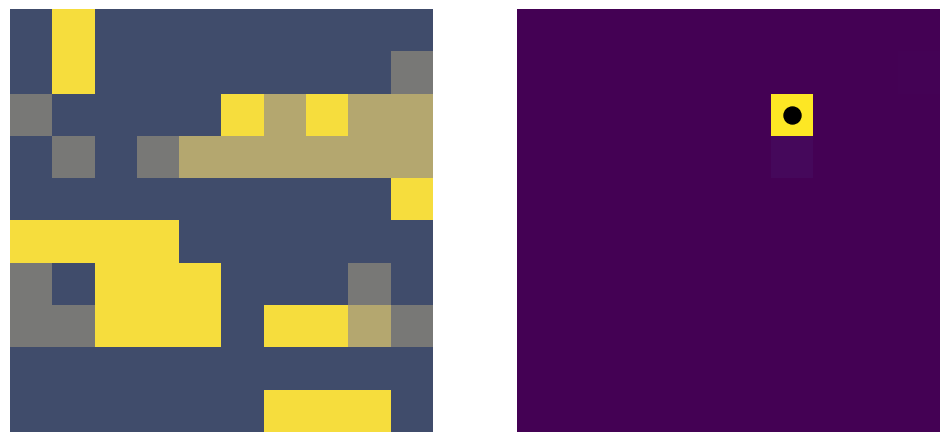

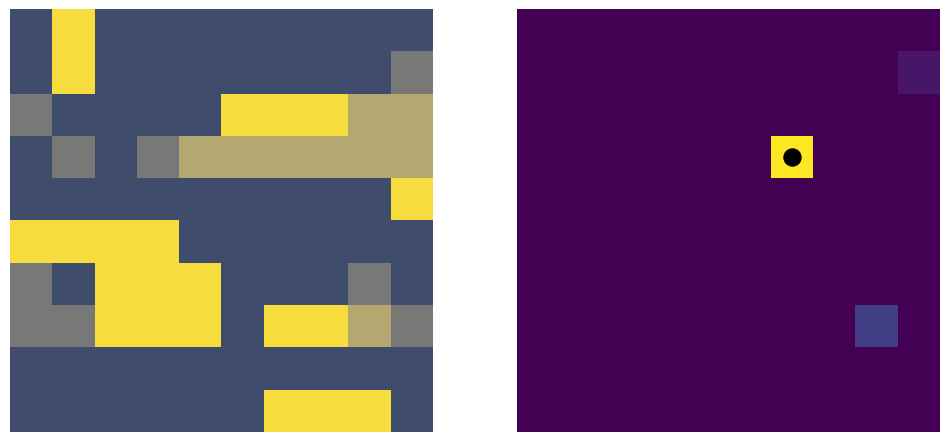

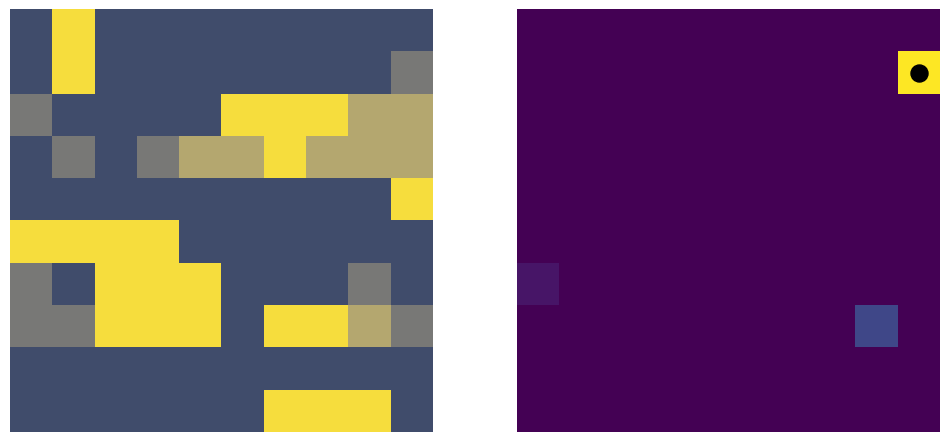

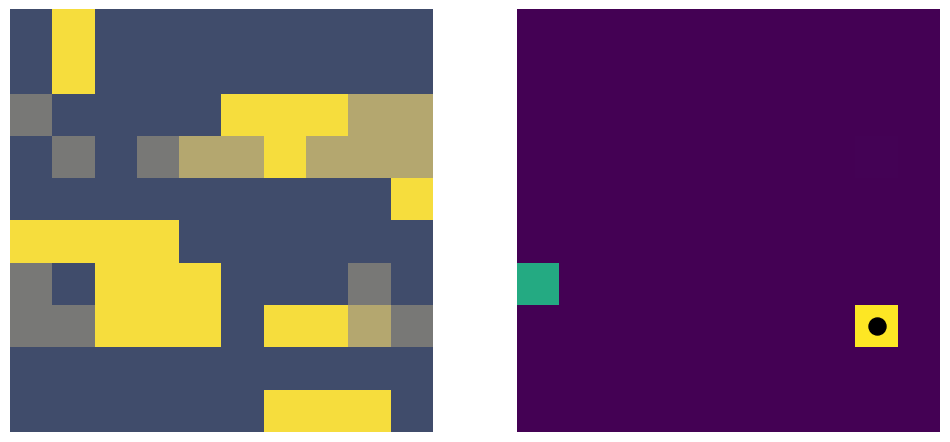

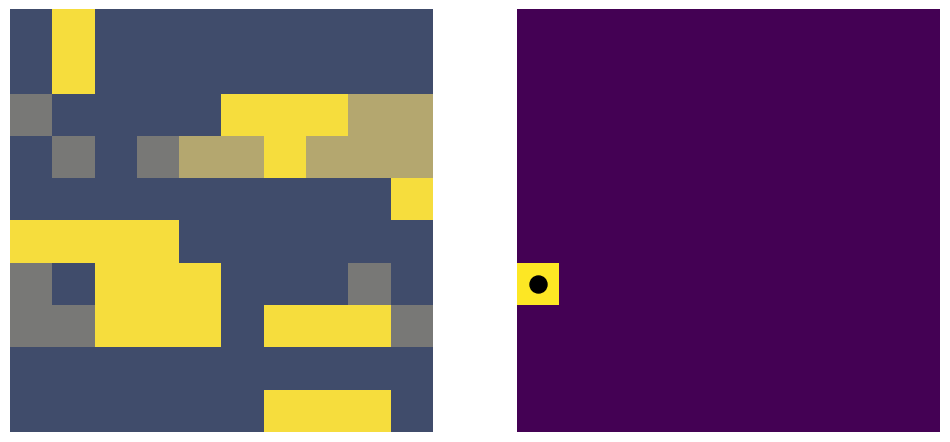

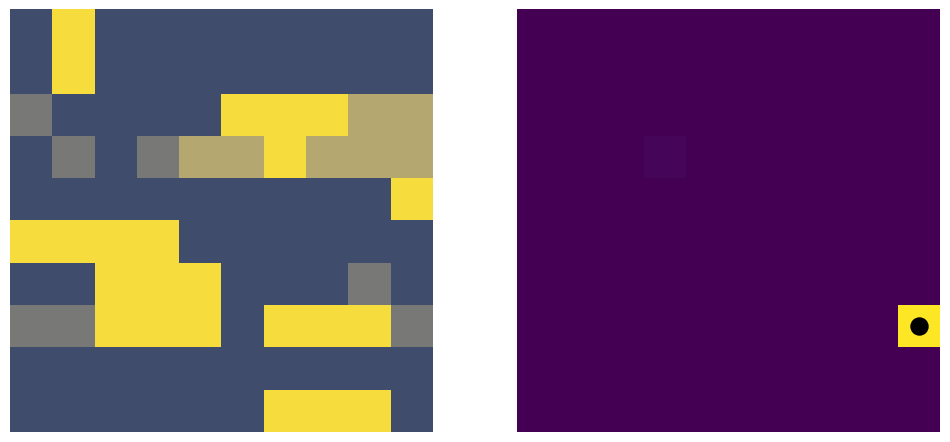

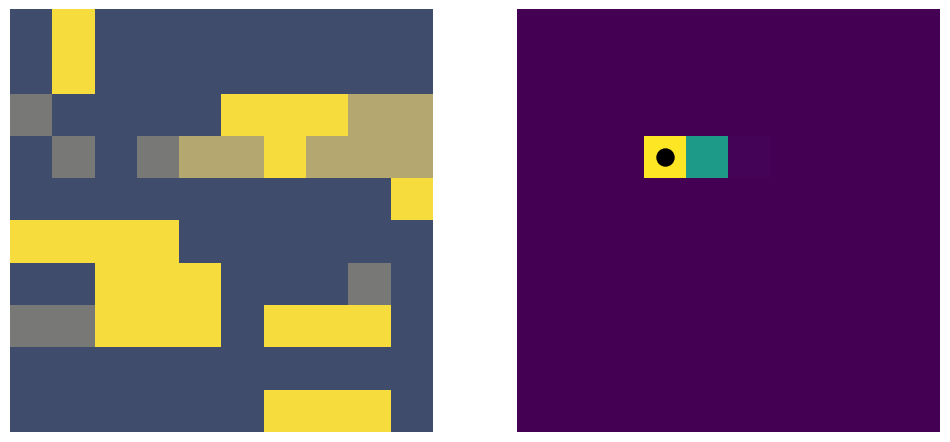

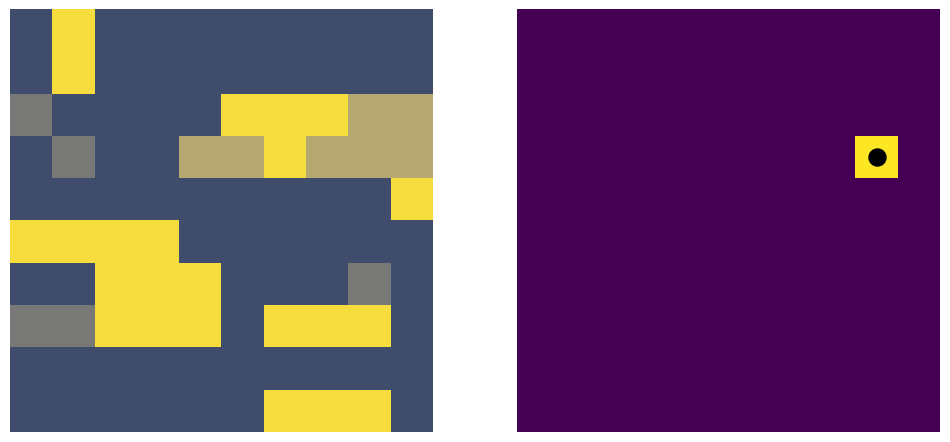

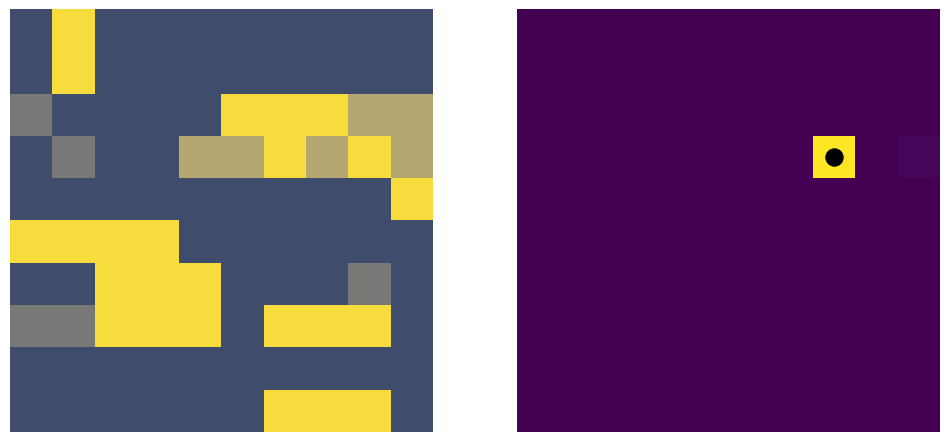

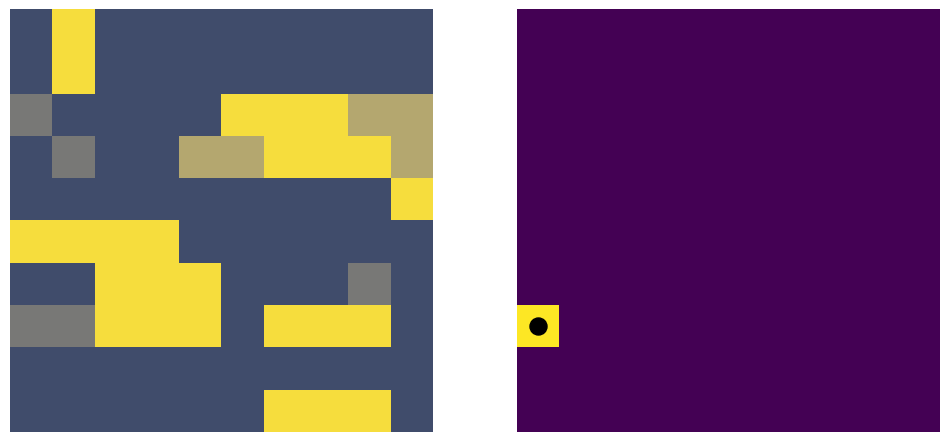

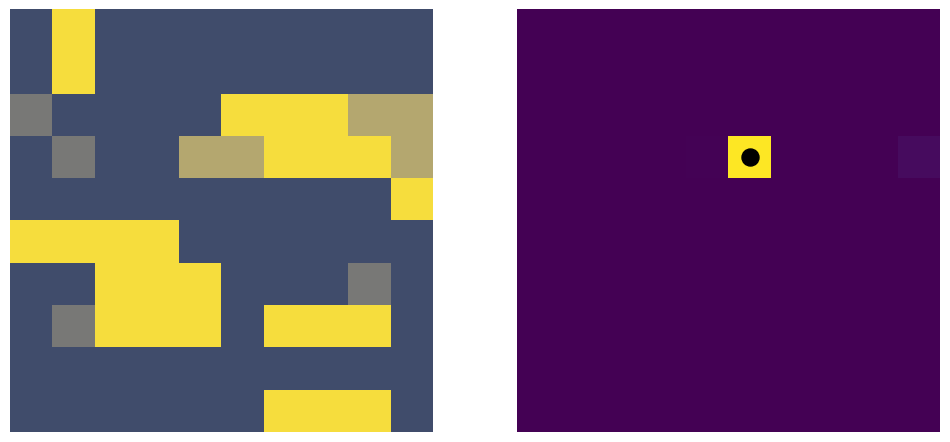

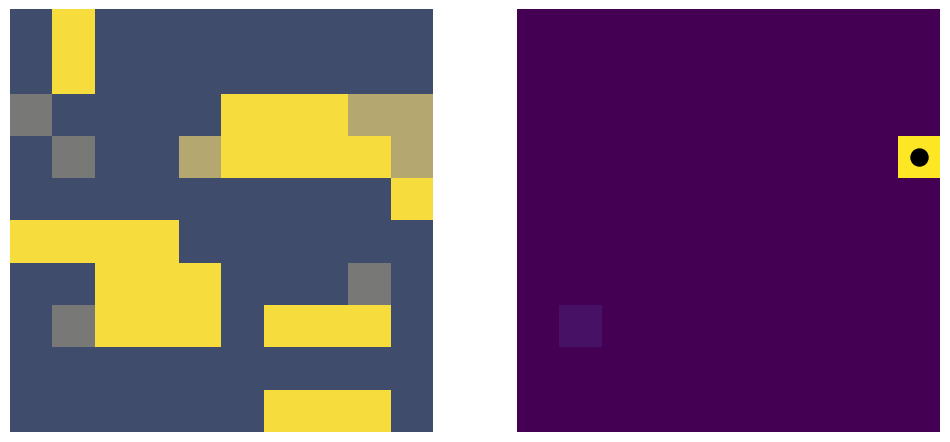

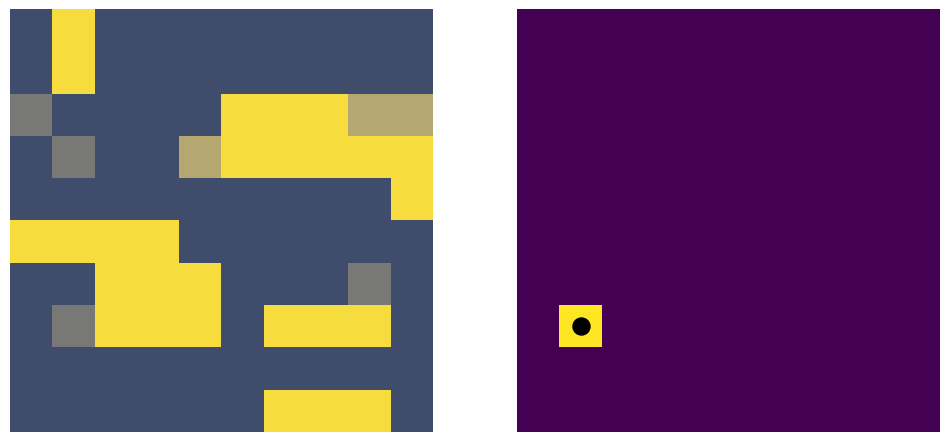

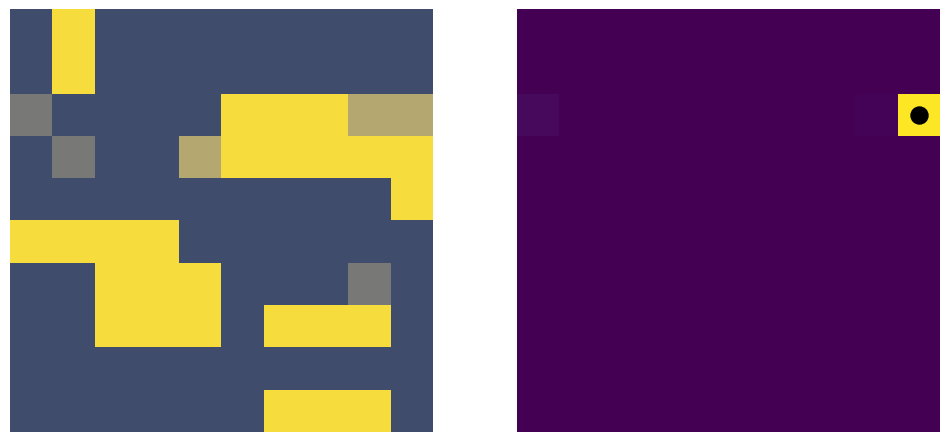

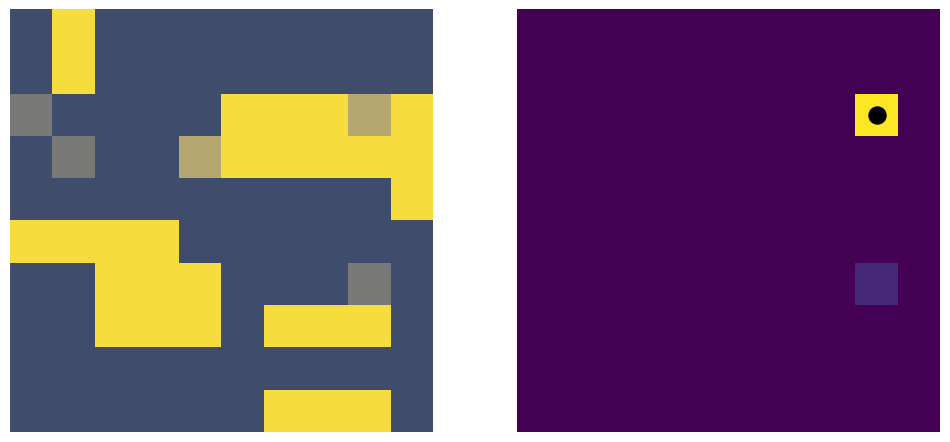

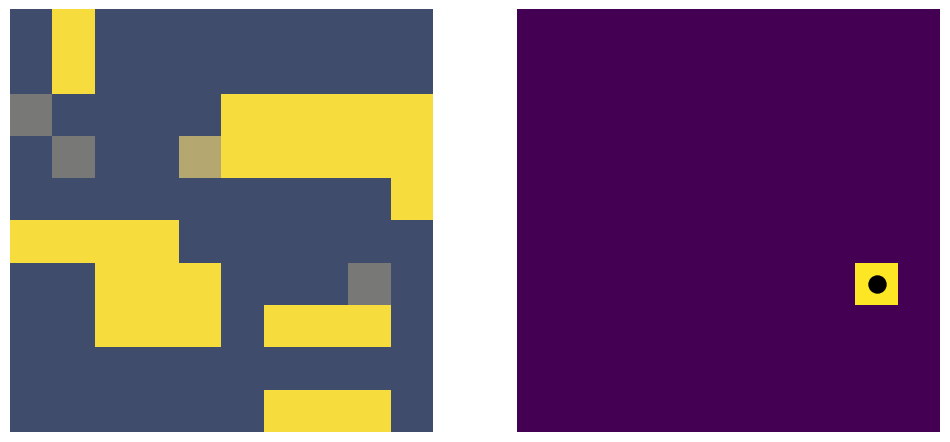

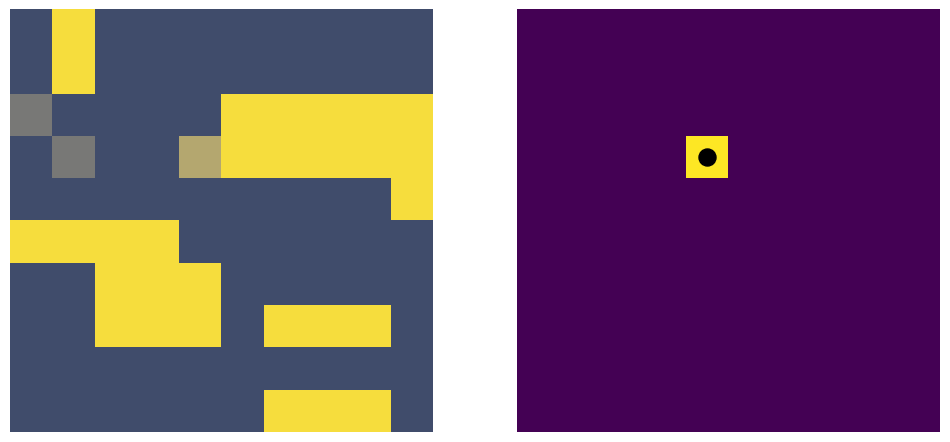

In [24]:
s = GameState()
hdn = create_sea()
while not GameClass.getEnded(s):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    plot_sea(hdn, s.det, ax=ax1)
    net.predict(encode_x(s.sea, s.det))
    p = softmax2d(net.p - 999999*np2t(s.det[None,:,:,None]))
    p = t2np(p)[0,:,:,0]
    i, j = argmax2d(p)
    s = GameClass.getNextState(s, (i,j), hdn)
    #ax2.imshow(p*(1-s.det))
    ax2.imshow(p)
    ax2.axis('off')
    ax2.scatter(j, i, c='black', alpha=1, s=150)
    plt.show()

In [47]:
p = net.p#*(1-s.det)
p

tensor([[[[ 1.1915e+01],
          [ 7.2766e+00],
          [-1.8939e+00],
          [ 9.5645e-01],
          [ 4.8554e+01],
          [-9.3654e+01],
          [-1.4575e+02],
          [ 2.1927e+02],
          [ 6.4511e+01],
          [ 4.4531e+00]],

         [[ 3.4605e+01],
          [ 4.0605e+01],
          [-3.3665e+01],
          [-2.2075e+01],
          [ 1.3510e+01],
          [ 2.9668e+01],
          [ 2.8602e+02],
          [ 3.7703e+01],
          [-1.8514e+01],
          [ 1.8148e+01]],

         [[ 2.6062e+01],
          [-4.7407e+01],
          [-5.2801e+01],
          [ 3.6707e+01],
          [ 4.0783e+01],
          [ 7.3393e+01],
          [ 2.3863e+01],
          [ 6.6006e+01],
          [ 3.4855e+01],
          [-2.5275e+00]],

         [[ 7.6510e+01],
          [ 1.2785e+02],
          [ 6.1085e+01],
          [ 1.7813e+01],
          [ 3.2311e+02],
          [ 2.3636e+02],
          [-5.3629e+01],
          [ 8.0009e+01],
          [-6.5910e+01],
          [ 7.0523e

In [27]:

p = net.p
b, h, w, c = p.shape
print(p.shape)
p = p-10000*np2t(s.det)
print(p.shape)
#p = p.reshape(b, -1)

torch.Size([32, 10, 10, 1])
torch.Size([32, 10, 10, 10])


In [28]:
s.det.shape

(10, 10)